<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Conformal_Prediction_for_Regression/CP_CO2_Emissions_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal_Prediction_on_CO2_Emissions_by_vehicles

### Prepare Workspace

In [ ]:
# Install necessary packages

In [ ]:
! pip install mapie &> /dev/null

In [ ]:
! pip install optuna &> /dev/null

In [ ]:
! pip install shap &> /dev/null

In [ ]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import shapiro
import optuna
import lightgbm
import sklearn
import mapie
import shap
import pickle
from lightgbm import LGBMRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
np.__version__

'1.26.4'

In [ ]:
pd.__version__

'2.1.4'

In [ ]:
matplotlib.__version__

'3.7.1'

In [ ]:
sns.__version__

'0.13.1'

In [ ]:
scipy.__version__

'1.13.1'

In [ ]:
optuna.__version__

'3.6.1'

In [ ]:
lightgbm.__version__

'4.4.0'

In [ ]:
sklearn.__version__

'1.3.2'

In [ ]:
mapie.__version__

'0.8.6'

In [ ]:
shap.__version__

'0.46.0'

In [ ]:
# Load dataset
df=pd.read_csv('/content/CO2_Emissions_Canada.csv')

### Have a peek of the data set

In [ ]:
# Explore dataset structure and basic info

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [ ]:
print(df.shape)

(7385, 12)


In [ ]:
print(df.columns)

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')


In [ ]:
df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33                  196  
1                           29                  221  
2                           48                  136  
3                           25                  255  
4                           27                  244

### Summary Statistics

In [ ]:
# Summarize categorical variable distributions
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
df[obj_cols].describe().T

count unique          top  freq
Make           7385     42         FORD   628
Model          7385   2053    F-150 FFV    32
Vehicle Class  7385     16  SUV - SMALL  1217
Transmission   7385     27          AS6  1324
Fuel Type      7385      5            X  3637

In [ ]:
# Summarize numerical variable distributions
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df[num_cols].describe().T

count        mean        std   min    25%  \
Engine Size(L)                    7385.0    3.160068   1.354170   0.9    2.0   
Cylinders                         7385.0    5.615030   1.828307   3.0    4.0   
Fuel Consumption City (L/100 km)  7385.0   12.556534   3.500274   4.2   10.1   
Fuel Consumption Hwy (L/100 km)   7385.0    9.041706   2.224456   4.0    7.5   
Fuel Consumption Comb (L/100 km)  7385.0   10.975071   2.892506   4.1    8.9   
Fuel Consumption Comb (mpg)       7385.0   27.481652   7.231879  11.0   22.0   
CO2 Emissions(g/km)               7385.0  250.584699  58.512679  96.0  208.0   

                                    50%    75%    max  
Engine Size(L)                      3.0    3.7    8.4  
Cylinders                           6.0    6.0   16.0  
Fuel Consumption City (L/100 km)   12.1   14.6   30.6  
Fuel Consumption Hwy (L/100 km)     8.7   10.2   20.6  
Fuel Consumption Comb (L/100 km)   10.6   12.6   26.1  
Fuel Consumption Comb (mpg)        27.0   32.0   69.0  
CO2 Emissions(g/km)               246.0  288.0  522.0

### Data Cleaning

In [ ]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(6282, 12)


In [ ]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(6282, 12)


In [ ]:
# Check missing values
missing = df.isnull().sum()/df.shape[0]*100
missing

Make                                0.0
Model                               0.0
Vehicle Class                       0.0
Engine Size(L)                      0.0
Cylinders                           0.0
Transmission                        0.0
Fuel Type                           0.0
Fuel Consumption City (L/100 km)    0.0
Fuel Consumption Hwy (L/100 km)     0.0
Fuel Consumption Comb (L/100 km)    0.0
Fuel Consumption Comb (mpg)         0.0
CO2 Emissions(g/km)                 0.0
dtype: float64

In [ ]:
# Rename some features for a practical use
df_1 = df.rename(columns={
      "Vehicle Class":"Vehicle_Class","Fuel Type":"Fuel_Type","Engine Size(L)":"Engine_Size",
      "Fuel Consumption City (L/100 km)":"Fuel_Consumption_City","Fuel Consumption Hwy (L/100 km)": "Fuel_Consumption_Hwy",
      "Fuel Consumption Comb (L/100 km)": "Fuel_Consumption_Comb",
      "Fuel Consumption Comb (mpg)":"Fuel_Consumption_Comb_","CO2 Emissions(g/km)":"CO2_Emissions"})

In [ ]:
# Split data set between target variable and features
X = df_1.copy()
y = X['CO2_Emissions']
X.drop(['CO2_Emissions'], axis=1, inplace=True)

### Functions

In [ ]:
# Define function to plot the distribution of the target variable
def plot_target(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.suptitle('CO2 Emissions Data Analysis',fontsize=15)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)


    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    plt.show()

In [ ]:
# Define function to plot the distribution of the numerical variables
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)


    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)


    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    plt.show()

In [ ]:
# Define function to plot scatterplot between the target and numerical variables
def plot_scatterplot(data,var):
    plt.rcParams['figure.figsize']=(10,5)
    sns.scatterplot(data=num2, x=var, y='CO2_Emissions')
    plt.suptitle('CO2_Emissions Distribution per {}'.format(var),fontsize=10)
    plt.xlabel('{}'.format(var), fontsize=15)
    plt.ylabel('CO2_Emissions', fontsize=15)
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.show()

In [ ]:
# Define function to plot the distribution of the categorical variables
def plot_cat(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    sns.countplot(x=data[var], data=data).set_title("Barplot {} Variable Distribution".format(var))
    plt.yticks(rotation=0, fontsize=5)
    plt.xticks(rotation=90, fontsize=10)
    plt.show()

In [ ]:
# Define function to plot boxplot between the target and categorical variables
def plot_boxplot2(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    sns.boxplot(x=data[var], y='CO2_Emissions', linewidth=2, palette="Set1", data=data)
    plt.suptitle('CO2_Emissions Distribution per {}'.format(var),fontsize=10)
    plt.xlabel('{}'.format(var), fontsize=15)
    plt.ylabel('CO2_Emissions', fontsize=15)
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=90, fontsize=15)
    plt.show()

In [ ]:
# Function to calculate predictions and scores of models
def calculate_predictions_and_scores(Model,X_test,regressor_type, alpha):
    # Make predictions on the test data
    if regressor_type == "QRegressor":
        y_pred, y_pis = Model.predict(X_test)
    else:
        y_pred, y_pis = Model.predict(X_test, alpha=alpha)

    # Store predictions in a dataframe
    predictions = y_test.to_frame()
    predictions.columns = ['y_true']
    predictions["point_prediction"] = y_pred
    predictions["lower"] = y_pis.reshape(-1, 2)[:, 0]
    predictions["upper"] = y_pis.reshape(-1, 2)[:, 1]

    # Calculate the coverage and width of the prediction intervals
    coverage = regression_coverage_score(
        y_test,
        y_pis[:, 0, 0],
        y_pis[:, 1, 0]
    )
    width = regression_mean_width_score(
        y_pis[:, 0, 0],
        y_pis[:, 1, 0]
    )

    # Calculate RMSE for lower, point, and upper predictions
    score_lower = np.sqrt(mean_squared_error(predictions[['y_true']], predictions[['lower']]))
    score_median = np.sqrt(mean_squared_error(predictions[['y_true']], predictions[['point_prediction']]))
    score_upper = np.sqrt(mean_squared_error(predictions[['y_true']], predictions[['upper']]))

    results = {
        "coverage": coverage,
        "width": width,
        "score_lower": score_lower,
        "score_median": score_median,
        "score_upper": score_upper
    }

    return results, predictions  # Return results and predictions separately



In [ ]:
# Function to calculate errors for models
def calculate_errors(predictions):
    error_lower = predictions["point_prediction"] - predictions["lower"]
    error_upper = predictions["upper"] - predictions["point_prediction"]

    # Ensure no negative values in yerr. If negative, make them zero.
    error_lower = np.maximum(error_lower, 0)
    error_upper = np.maximum(error_upper, 0)

    # Combine lower and upper errors into one array
    error = [error_lower, error_upper]
    return error


# Function to plot errors of models
def plot_error(models_predictions, calculate_errors):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (model_name, predictions) in zip(axes, models_predictions):
        error = calculate_errors(predictions)

        ax.errorbar(predictions["y_true"], predictions["point_prediction"],
                yerr=error,
                ecolor='gray', linestyle='', marker="o", capsize=8)

        ax.axline([0, 0], [1, 1], color="red", linestyle='--', lw=3, zorder=3)
        ax.set_xlim(0)
        ax.set_ylim(0)
        ax.set_xlabel('True CO2 Emissions')
        ax.set_ylabel('Predicted CO2 Emissions')
        ax.set_title(f'{model_name} Method')

    plt.tight_layout()
plt.show()

In [ ]:
# Function to plot predictions of models
def plot_prediction(models_predictions):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (model_name, predictions) in zip(axes, models_predictions):
        # Re-sort for plot
        sorted_predictions = predictions.sort_values(by=['y_true']).reset_index(drop=True)

        ax.plot(sorted_predictions["y_true"], 'o', markersize=5, color='blue', label="y_true")
        ax.plot(sorted_predictions["point_prediction"], 'o', markersize=3, color='red',label="y_prediction")
        ax.fill_between(np.arange(len(sorted_predictions)),
                    sorted_predictions["lower"],
                    sorted_predictions["upper"],
                    alpha=0.8, color="green", label="prediction interval")

        ax.set_xticks([])
        ax.set_xlim([0, len(sorted_predictions)])
        ax.set_ylabel("True value")
        ax.set_title(f'{model_name} Method')
        ax.legend(loc="upper left", fontsize=10)

    plt.tight_layout()
plt.show()

In [ ]:
# General function to calculate binned coverage or width
def calculate_binned_metric(predictions, bin_edges, metric='coverage'):
    predictions['bin'] = np.digitize(predictions['point_prediction'], bin_edges, right=True)
    bins = predictions['bin'].unique()
    binned_metric = {}
    for bin in bins:
        bin_data = predictions[predictions['bin'] == bin]
        if metric == 'coverage':
            metric_value = ((bin_data['y_true'] >= bin_data['lower']) & (bin_data['y_true'] <= bin_data['upper'])).mean()
        elif metric == 'width':
            metric_value = (bin_data['upper'] - bin_data['lower']).mean()
        binned_metric[bin] = metric_value
    return binned_metric

# Function to get combined bin edges
def get_bin_edges(*prediction_frames, n_bins=10):
    all_point_predictions = pd.concat([df['point_prediction'] for df in prediction_frames])
    bin_edges = np.linspace(all_point_predictions.min(), all_point_predictions.max(), n_bins)
    return bin_edges

# General function to combine binned metrics
def combine_binned_metrics(binned_metrics_dict, metric='Coverage'):
    data = []
    for model_name, metrics in binned_metrics_dict.items():
        for bin, value in metrics.items():
            data.append([bin, model_name, value])
    return pd.DataFrame(data, columns=['Bin', 'Model', metric])

# Main functions to calculate and combine binned coverage and width
def main_binned_metric(cqr_predictions_df, naive_predictions_df, jacknife_predictions_df, jacknife_plus_predictions_df, metric='coverage'):
    bin_edges = get_bin_edges(cqr_predictions_df, naive_predictions_df, jacknife_predictions_df, jacknife_plus_predictions_df)
    metrics_funcs = {
        'coverage': calculate_binned_metric,
        'width': calculate_binned_metric
    }

    binned_metrics = {
        "CQR": metrics_funcs[metric](cqr_predictions_df, bin_edges, metric),
        "Naive": metrics_funcs[metric](naive_predictions_df, bin_edges, metric),
        "Jacknife": metrics_funcs[metric](jacknife_predictions_df, bin_edges, metric),
        "Jacknife+": metrics_funcs[metric](jacknife_plus_predictions_df, bin_edges, metric)
    }

    binned_metrics_df = combine_binned_metrics(binned_metrics, metric.capitalize())

    return binned_metrics_df

# Plotting binned metric
def plot_binned_metric(metric, binned_metrics_df):
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Bin', y=metric.capitalize(), hue='Model', data=binned_metrics_df, palette=["green", "blue", "orange", "red"])
    plt.axhline(y=0.9 if metric == 'coverage' else 0.45, color='gray', linestyle='--')
    plt.title(f'Binned {metric.capitalize()} for Different Methods')
    plt.xlabel('Bins')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1 if metric == 'coverage' else None)  # Coverage should be between 0 and 1
    plt.legend(title='Method', fontsize=7, title_fontsize=7)
    plt.show()



### Target Analysis

In [ ]:
# Univariate analysis looking at Mean, Variance, Standard Deviation, Skewness and Kurtosis
print(y.name,
      '\nMean :', np.mean(y),
      '\nVariance :', np.var(y),
      '\nStandard Deviation :', np.var(y)**0.5,
      '\nSkewness :', stats.skew(y),
      '\nKurtosis :', stats.kurtosis(y))

CO2_Emissions 
Mean : 251.1577523081821 
Variance : 3514.79507600487 
Standard Deviation : 59.28570718145201 
Skewness : 0.5563189625234934 
Kurtosis : 0.43986442942205617


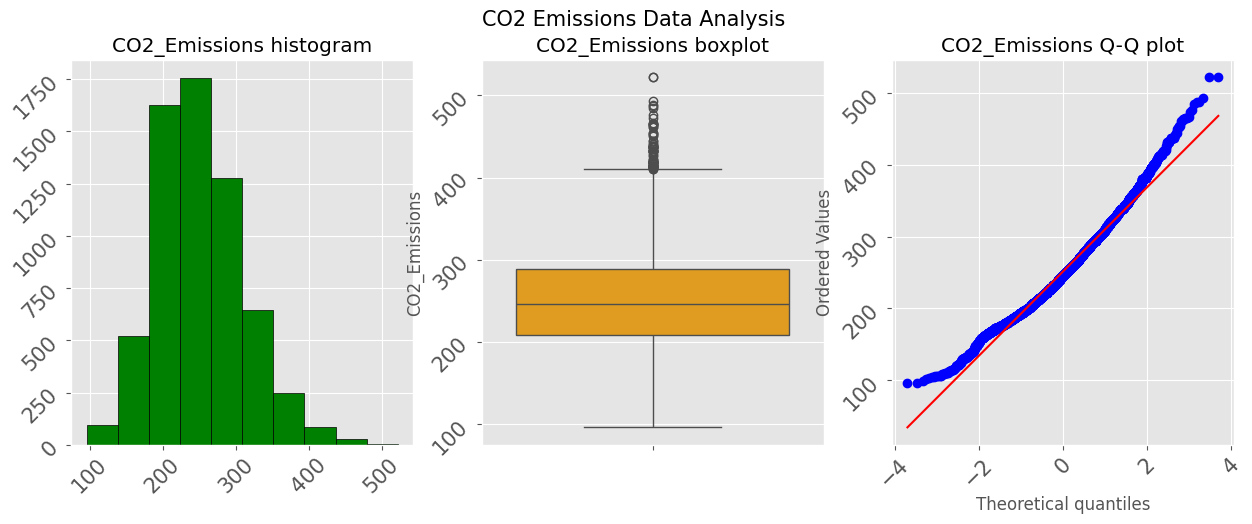

In [ ]:
plot_target(df_1, var='CO2_Emissions')

### Numerical Features Analysis

In [ ]:
# Select numerical columns
numerical_cols = [var for var in X.columns if X[var].dtype in ['int64','float64']]

In [ ]:
# Subset with numerical features
num = X[numerical_cols]
num.columns

Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb',
       'Fuel_Consumption_Comb_'],
      dtype='object')

In [ ]:
# Plot distributions of numerical features

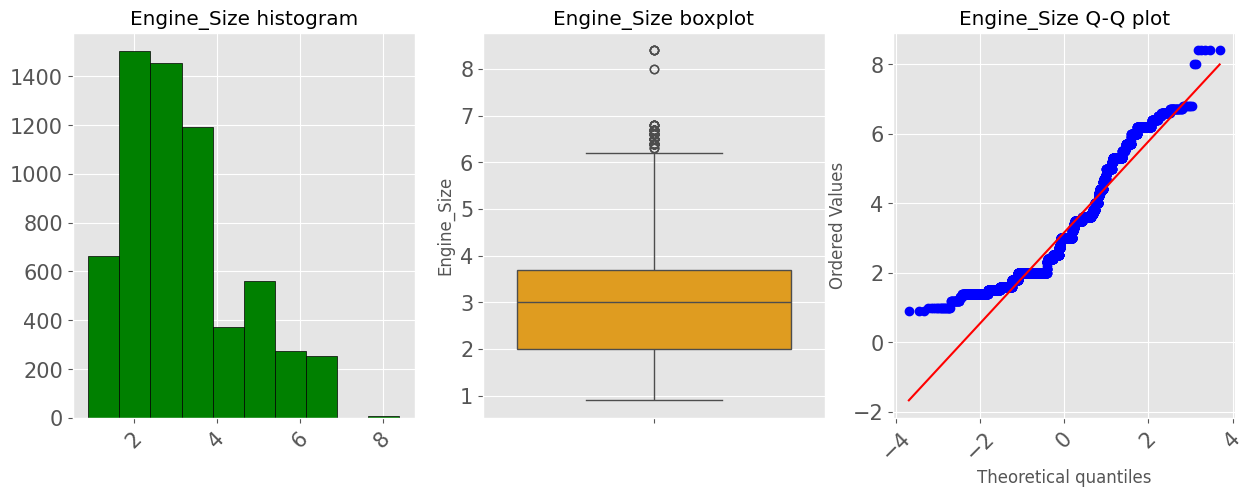

In [ ]:
plot_num(num, var='Engine_Size')

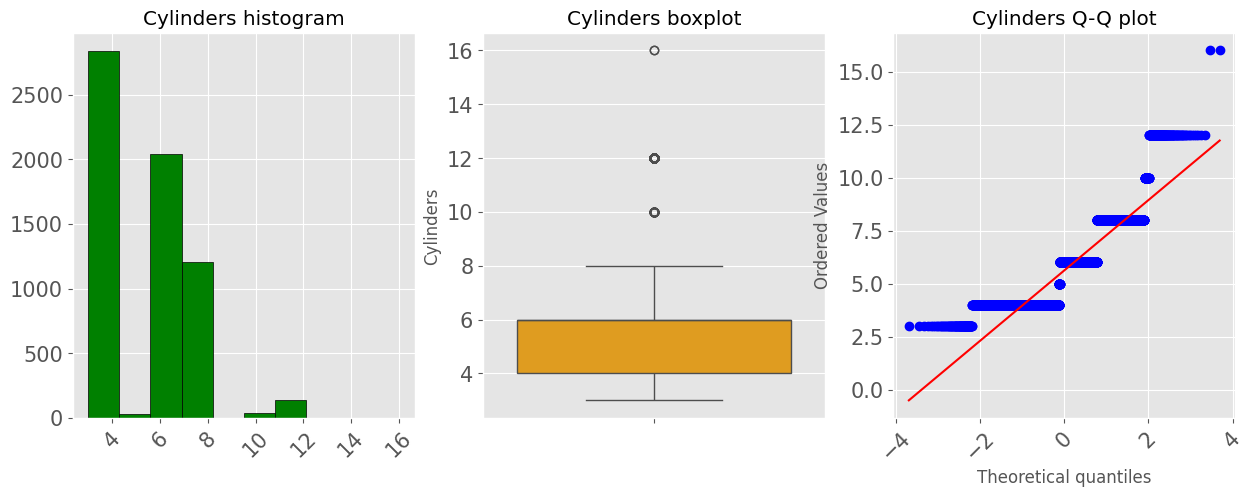

In [ ]:
plot_num(num, var='Cylinders')

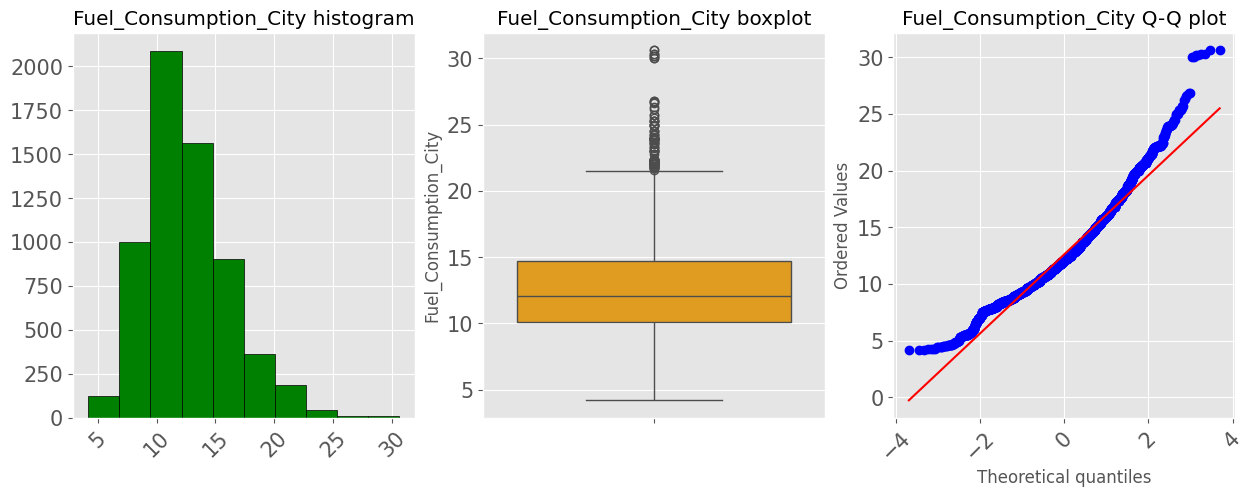

In [ ]:
plot_num(num, var='Fuel_Consumption_City')

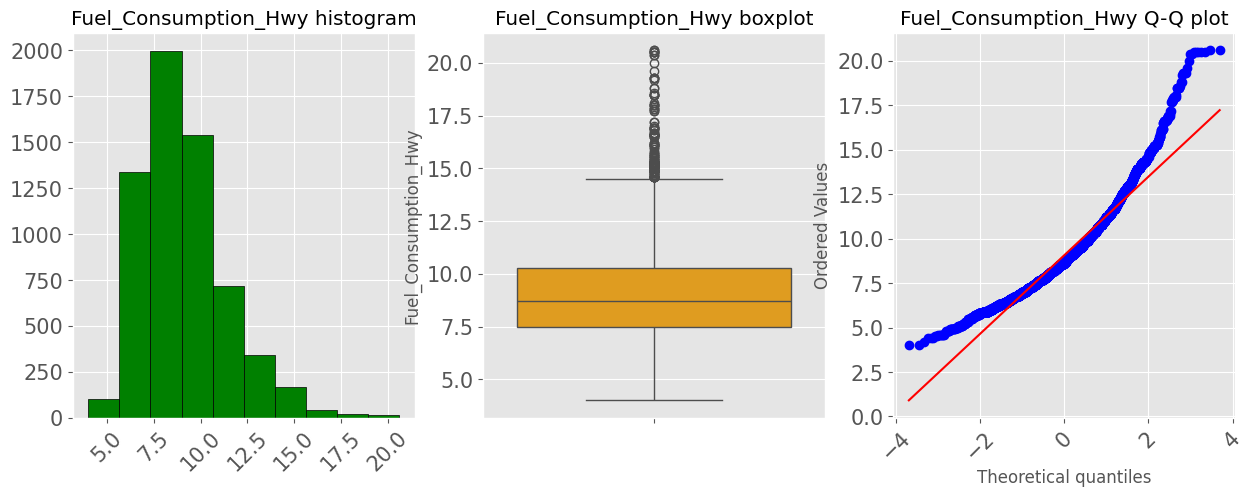

In [ ]:
plot_num(num, var='Fuel_Consumption_Hwy')

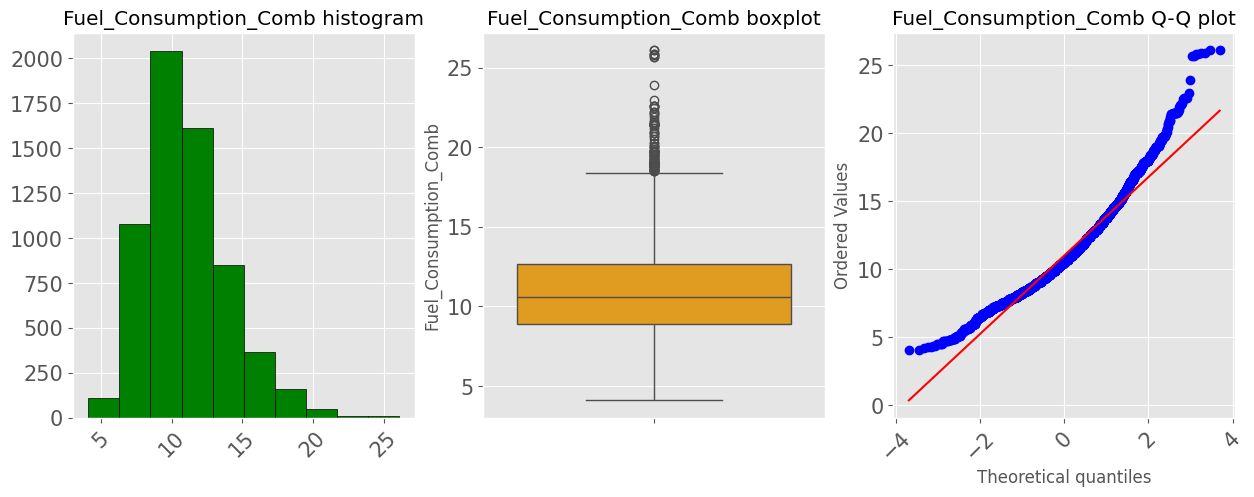

In [ ]:
plot_num(num, var='Fuel_Consumption_Comb')

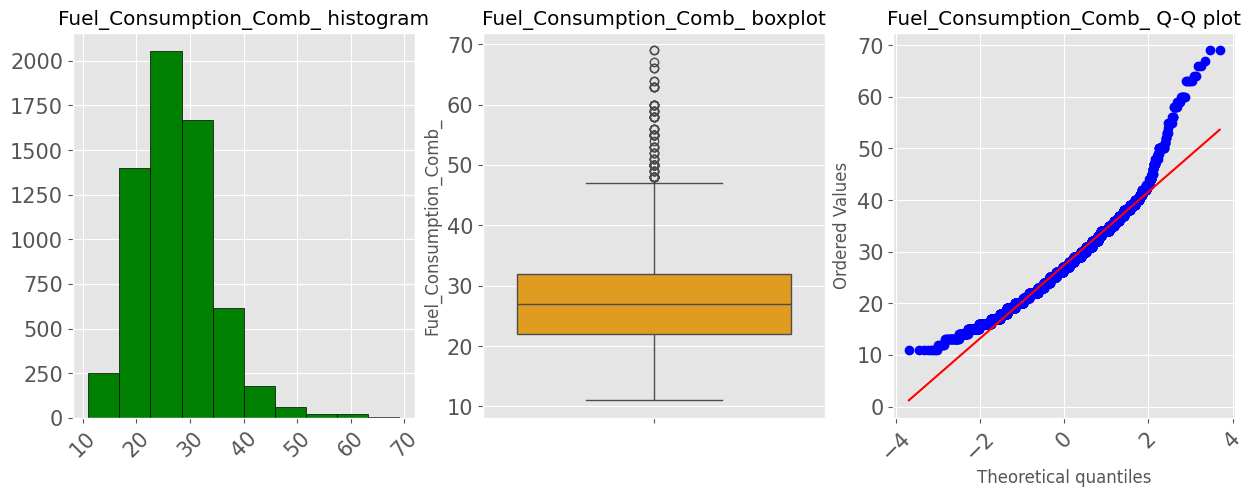

In [ ]:
plot_num(num, var='Fuel_Consumption_Comb_')

In [ ]:
# Combine target variable with numerical features for scatter plots
num2= pd.concat([y,num], axis=1)

In [ ]:
# Plot scatterplots between target and numerical features

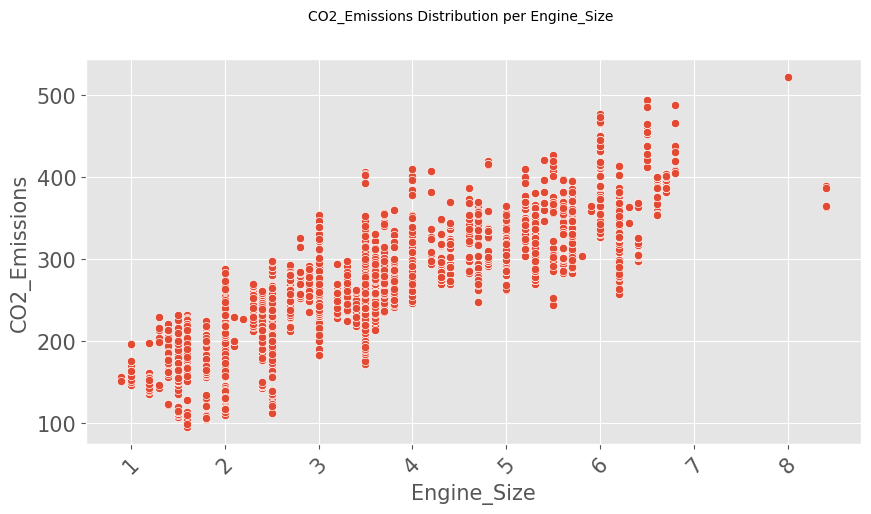

In [ ]:
plot_scatterplot(num2, var='Engine_Size')

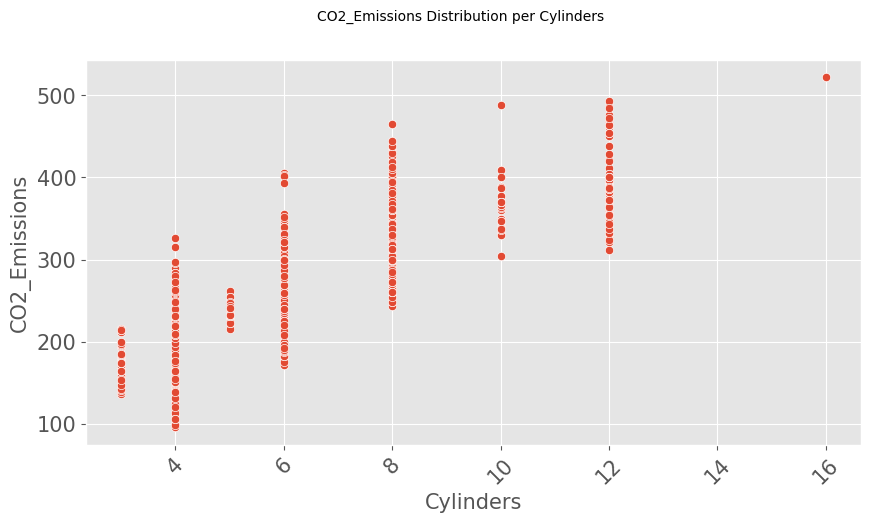

In [ ]:
plot_scatterplot(num2, var='Cylinders')

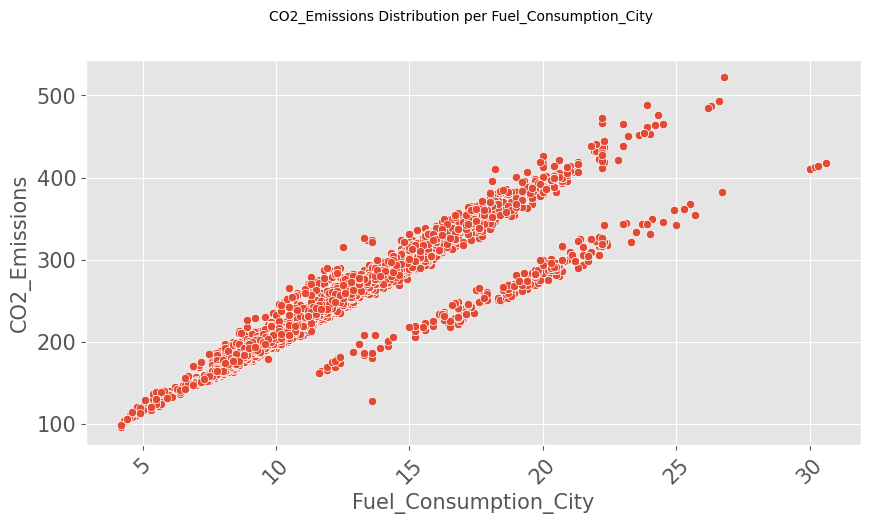

In [ ]:
plot_scatterplot(num2, var='Fuel_Consumption_City')

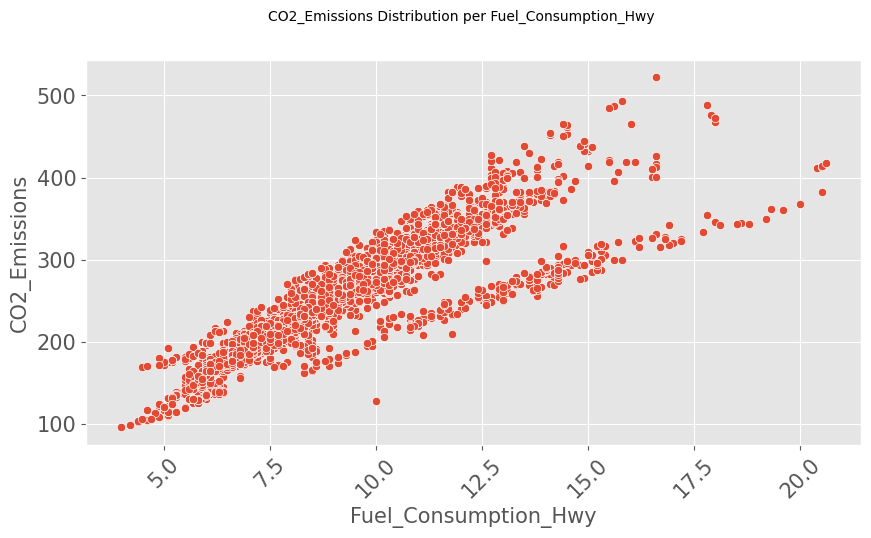

In [ ]:
plot_scatterplot(num2, var='Fuel_Consumption_Hwy')

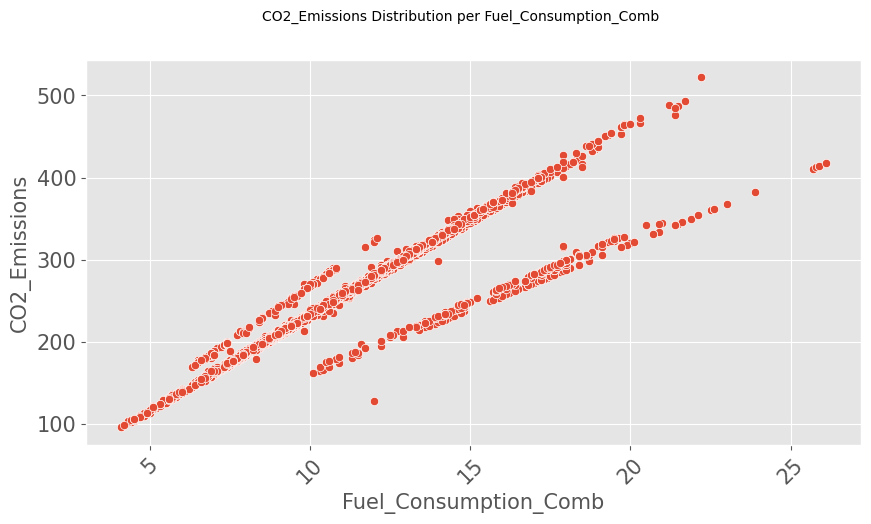

In [ ]:
plot_scatterplot(num2, var='Fuel_Consumption_Comb')

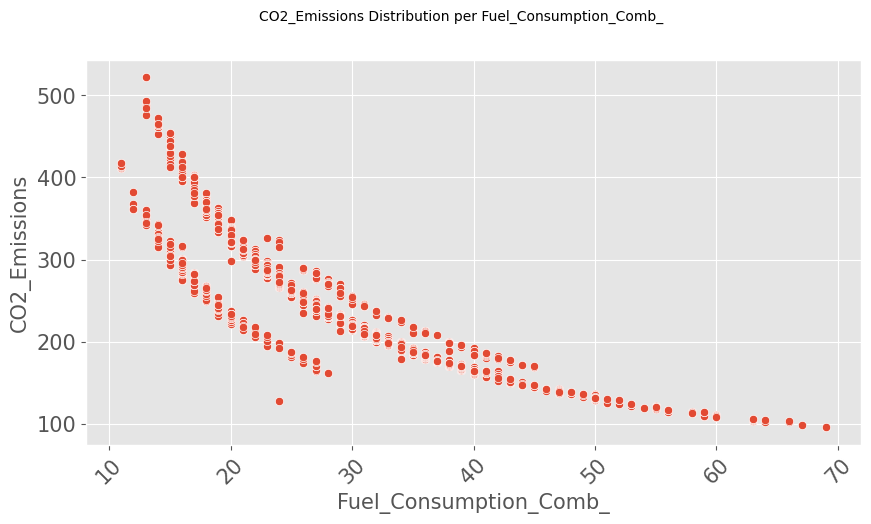

In [ ]:
plot_scatterplot(num2, var='Fuel_Consumption_Comb_')

### Categorical Features Analysis

In [ ]:
# let's have a look at how many labels for categorical features
for col in X.columns:
    if X[col].dtype =="object":
        print(col, ': ', len(X[col].unique()), ' labels')

Make :  42  labels
Model :  2053  labels
Vehicle_Class :  16  labels
Transmission :  27  labels
Fuel_Type :  5  labels


In [ ]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() <= 50 and
                    X[cname].dtype == "object"]

In [ ]:
cat=X[categorical_cols]

In [ ]:
cat.columns

Index(['Make', 'Vehicle_Class', 'Transmission', 'Fuel_Type'], dtype='object')

In [ ]:
# Plot distributions of categorical features

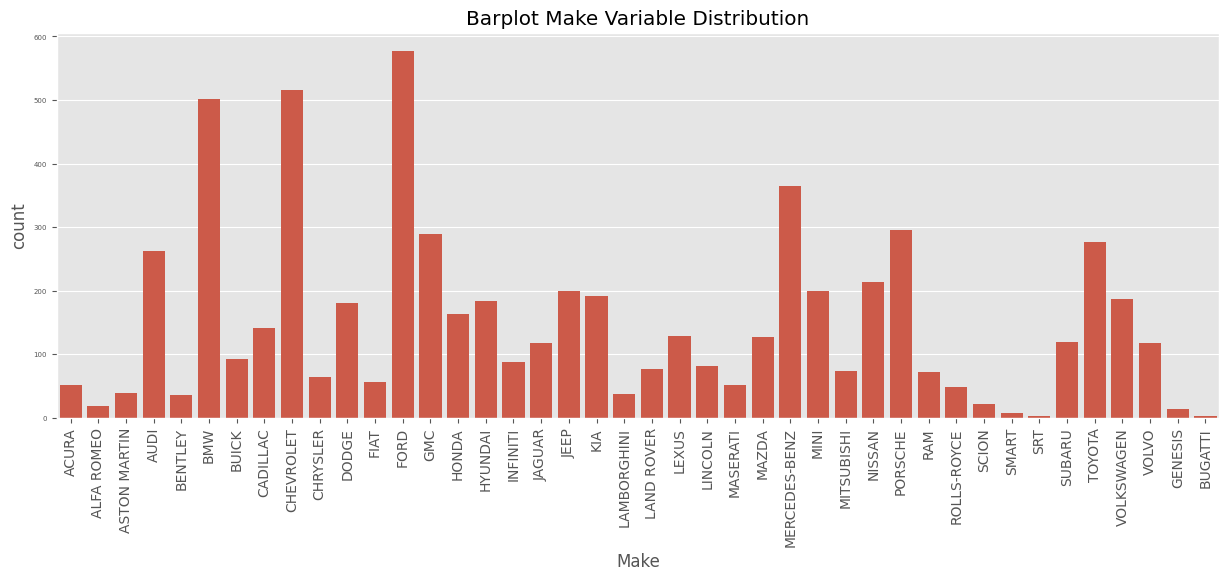

In [ ]:
plot_cat(cat, var = 'Make')

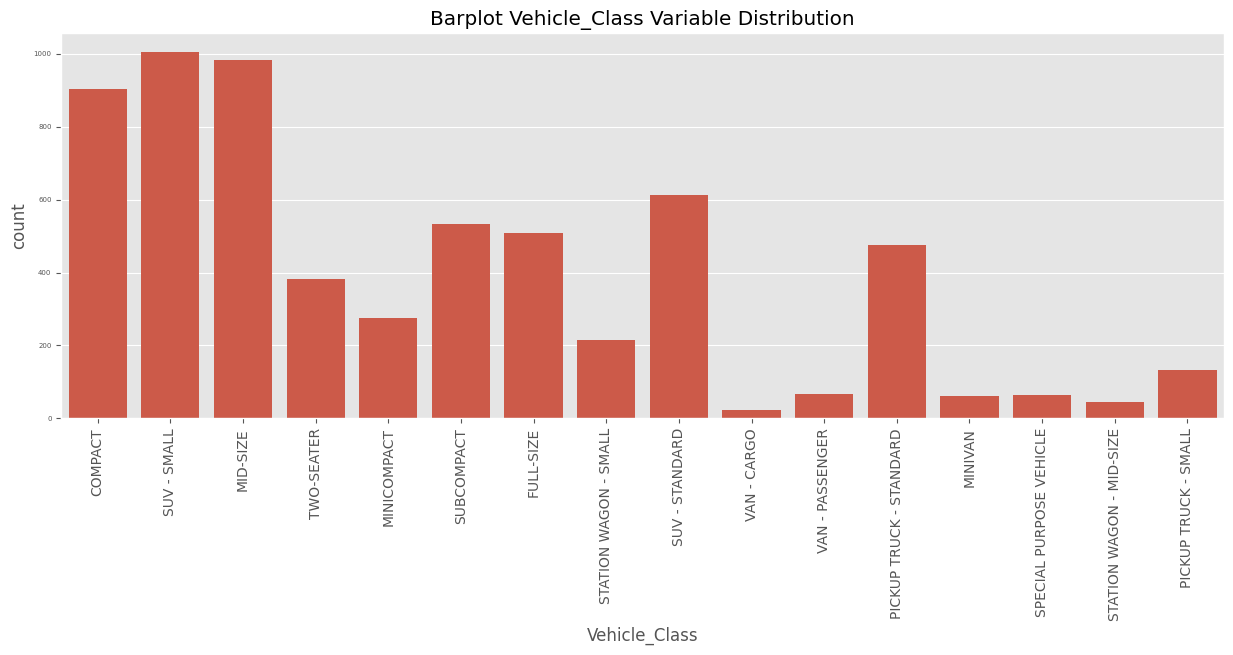

In [ ]:
plot_cat(cat, var='Vehicle_Class')

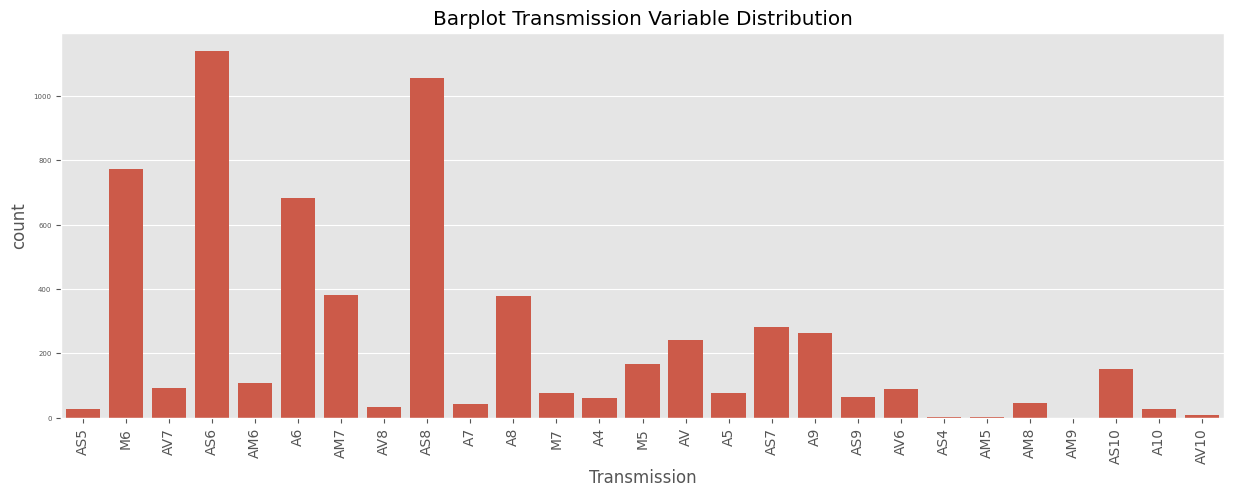

In [ ]:
plot_cat(cat, var='Transmission')

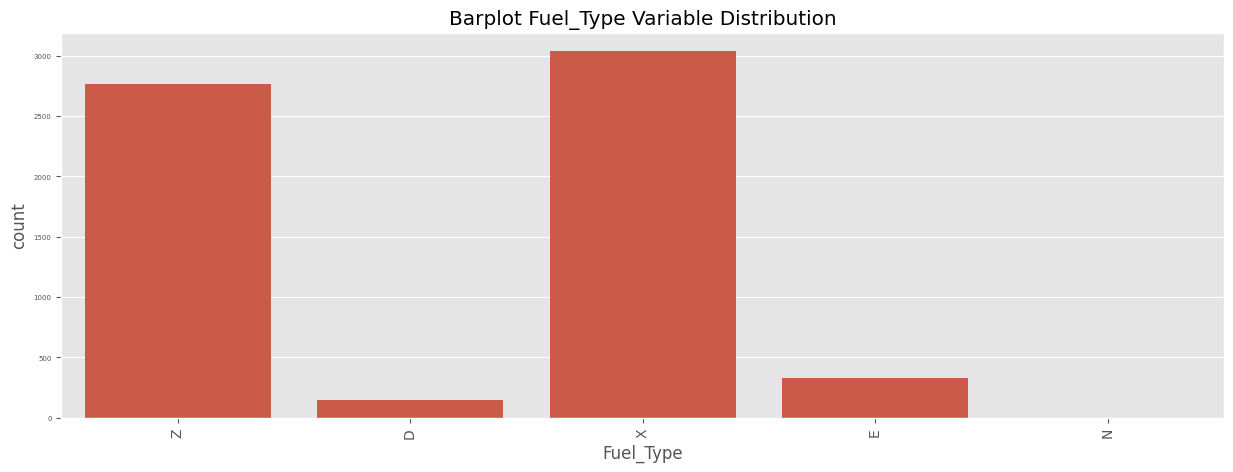

In [ ]:
plot_cat(cat,var='Fuel_Type')

In [ ]:
# Combine target variable with categorical features for box plots
cat2=pd.concat([y,cat], axis=1)

In [ ]:
# Plot boxplots between target and categorical features

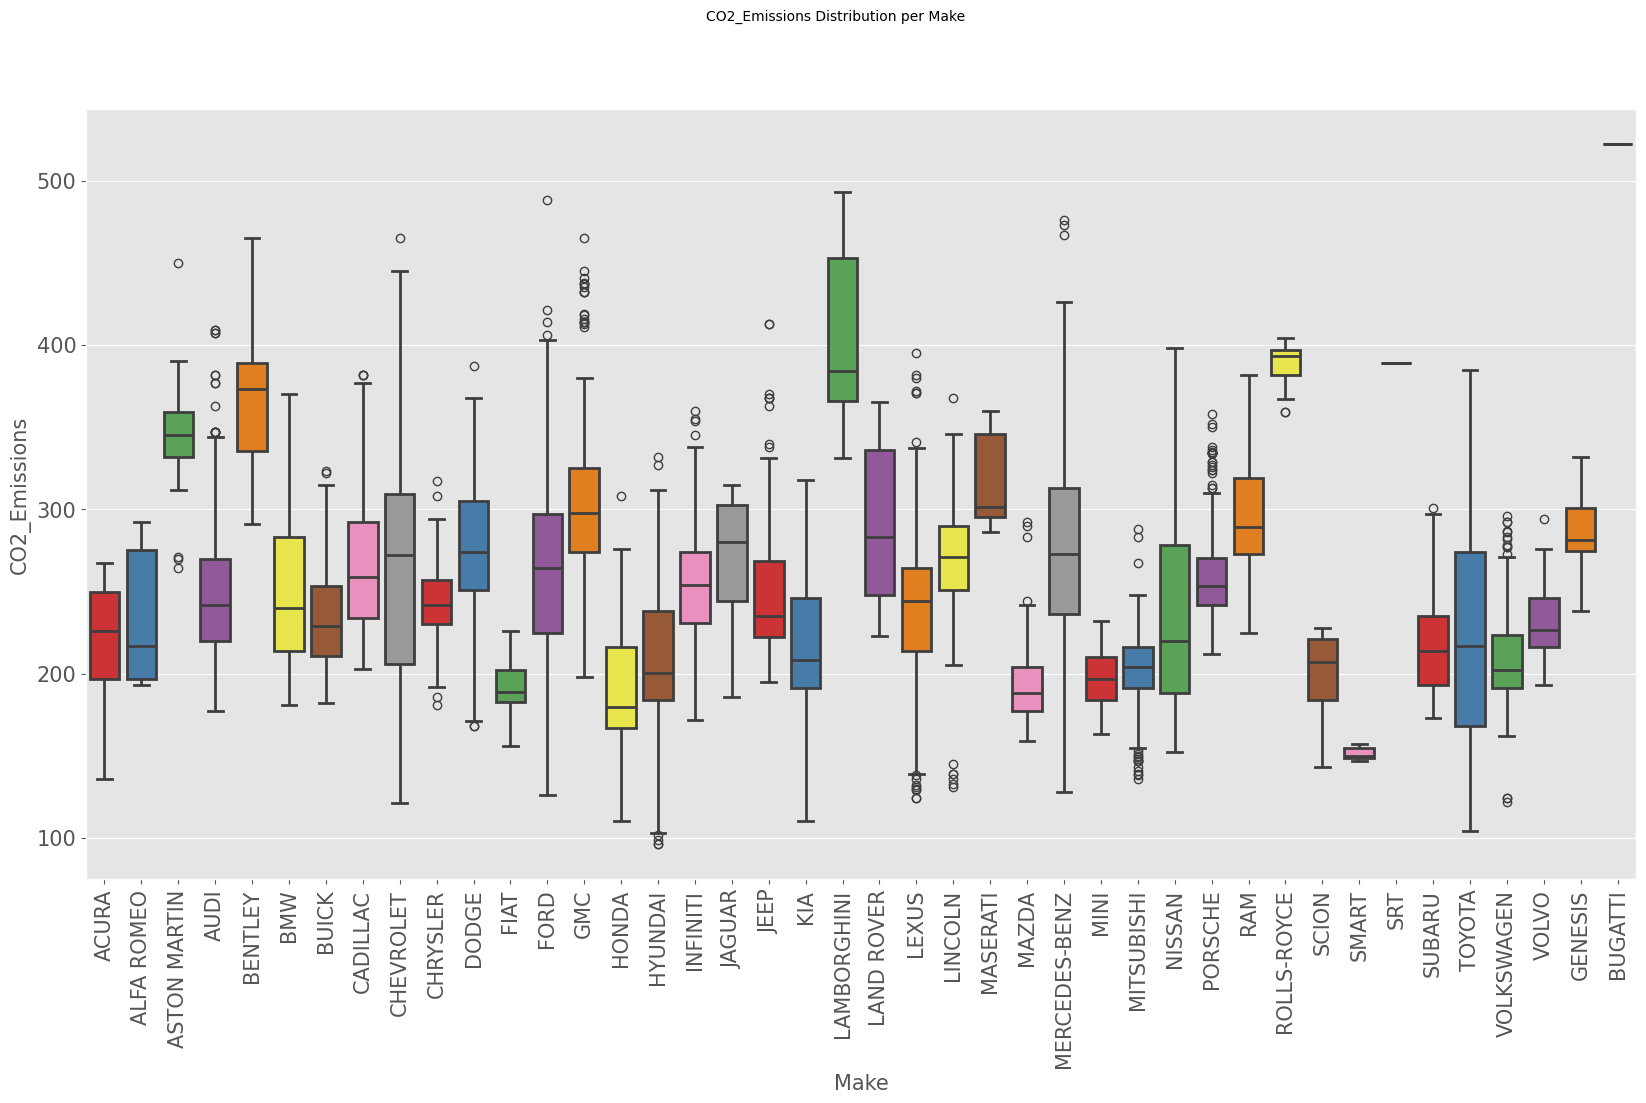

In [ ]:
plot_boxplot2(cat2, var='Make')

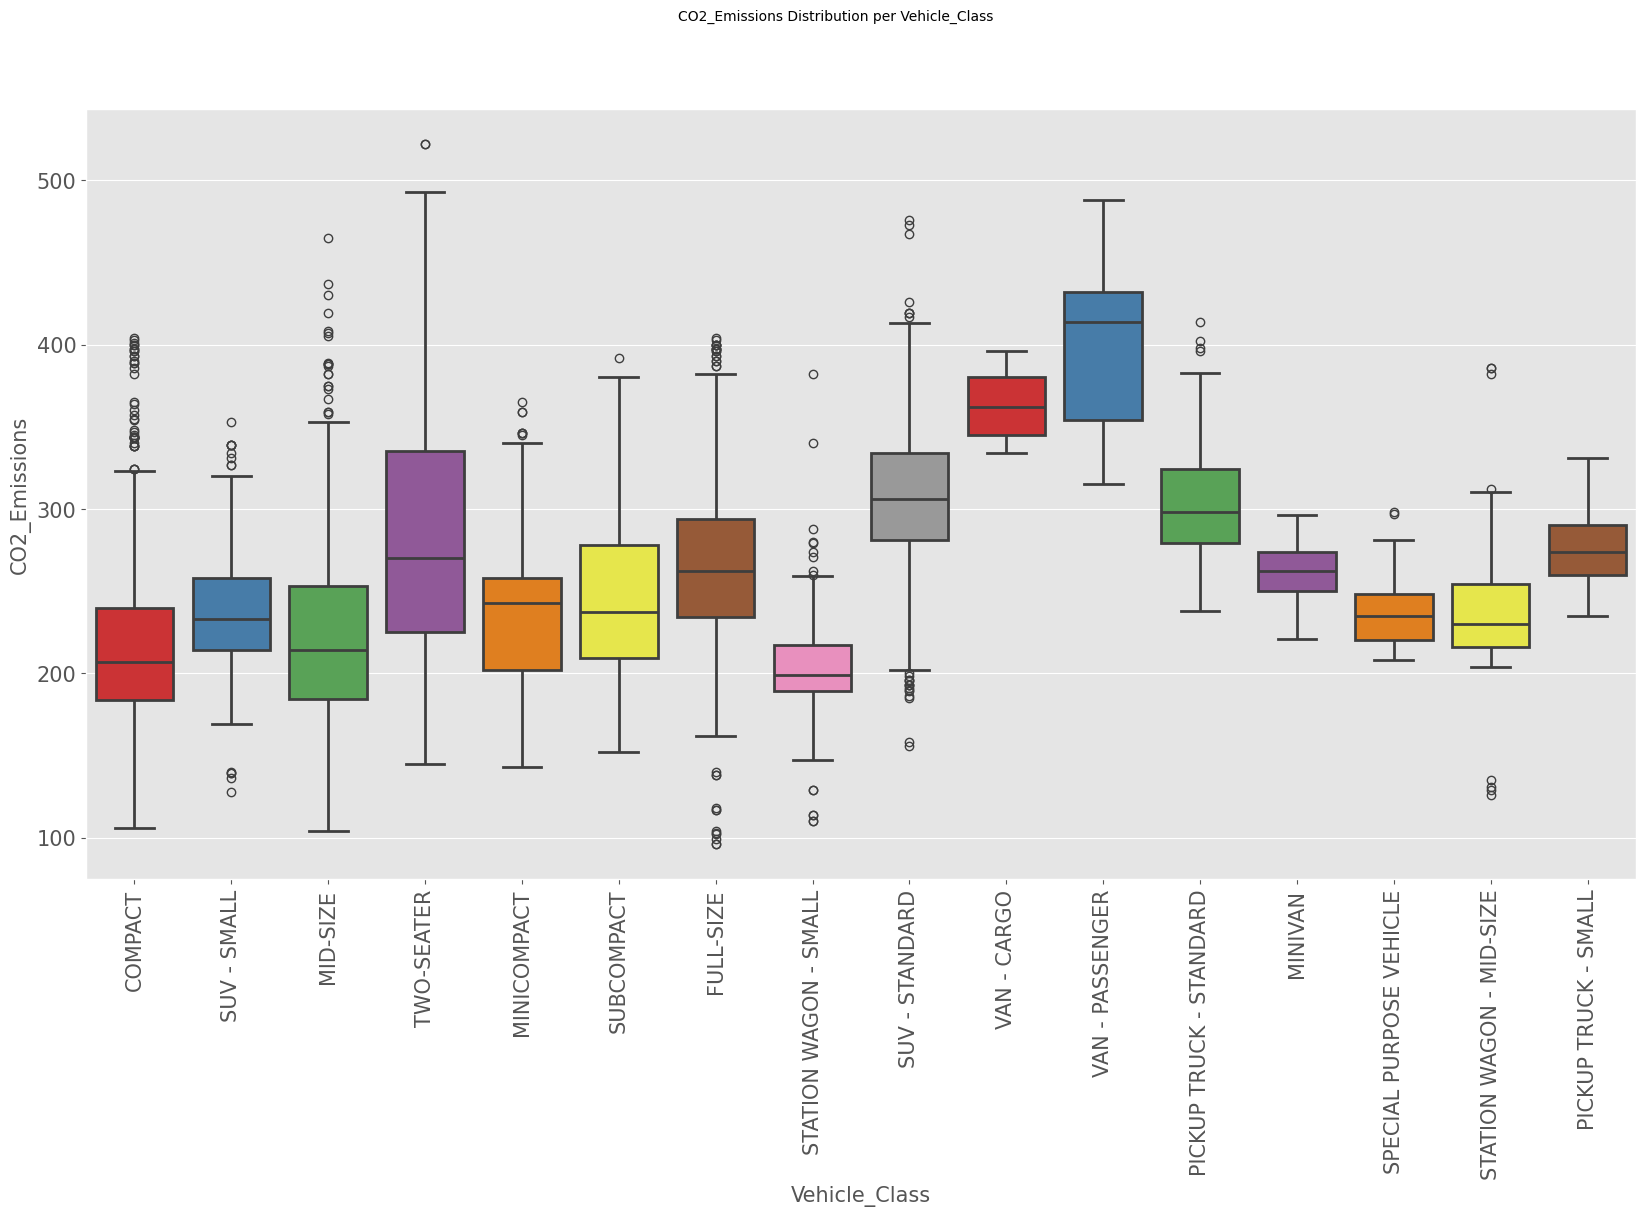

In [ ]:
plot_boxplot2(cat2, var='Vehicle_Class')

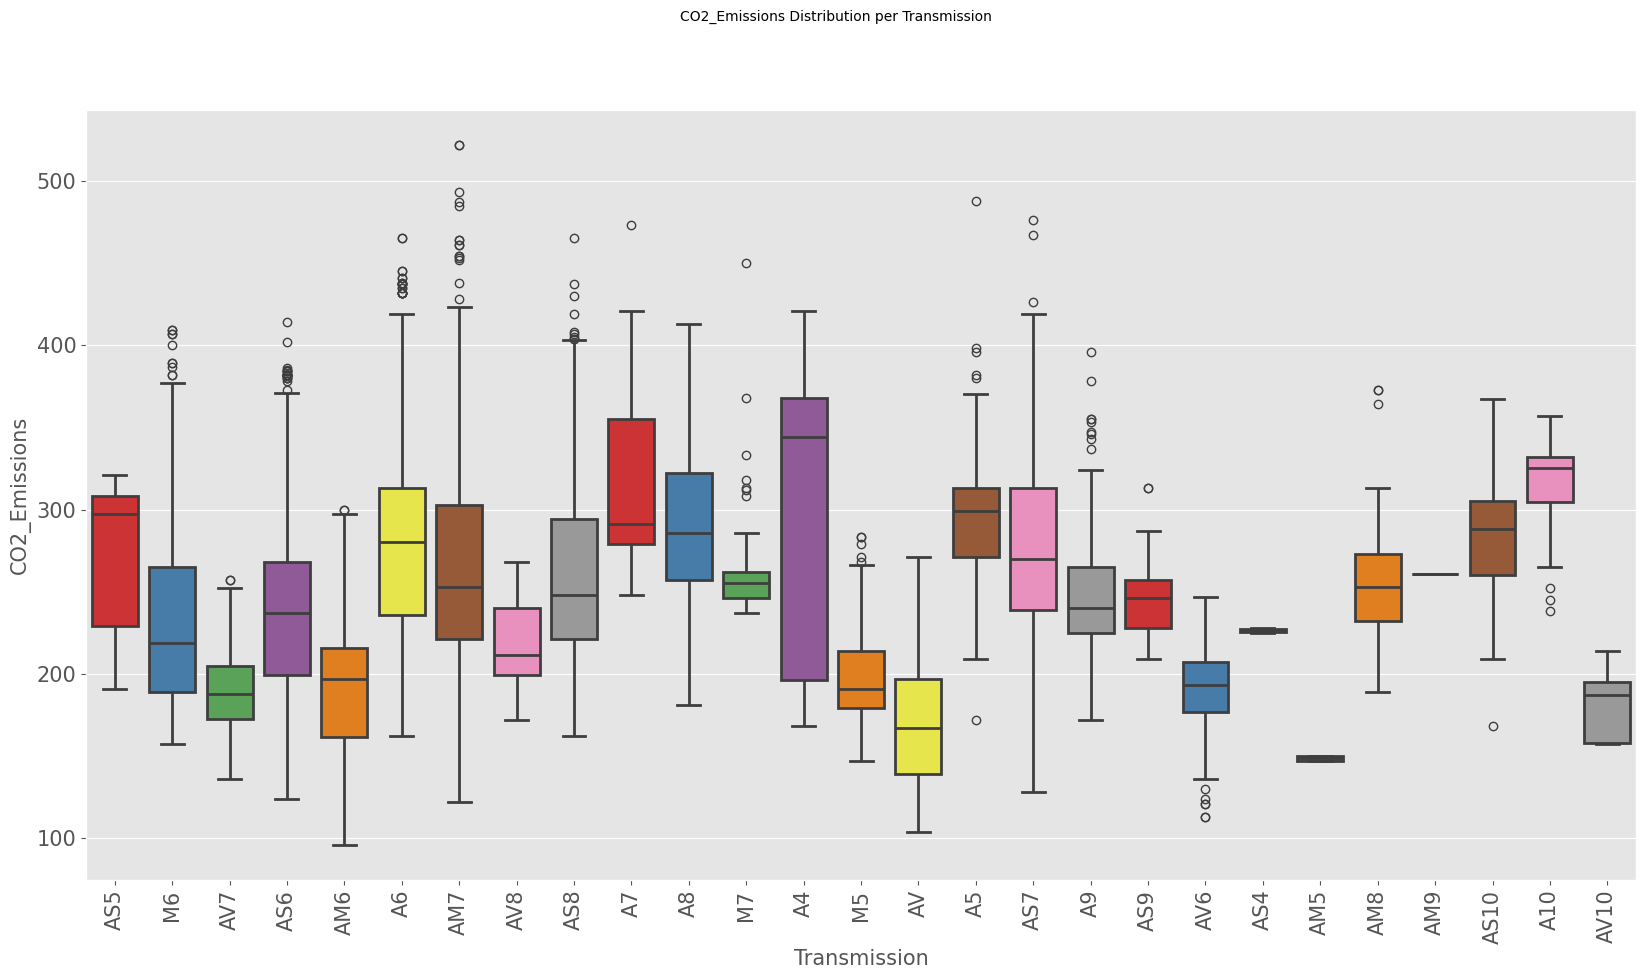

In [ ]:
plot_boxplot2(cat2, var='Transmission')

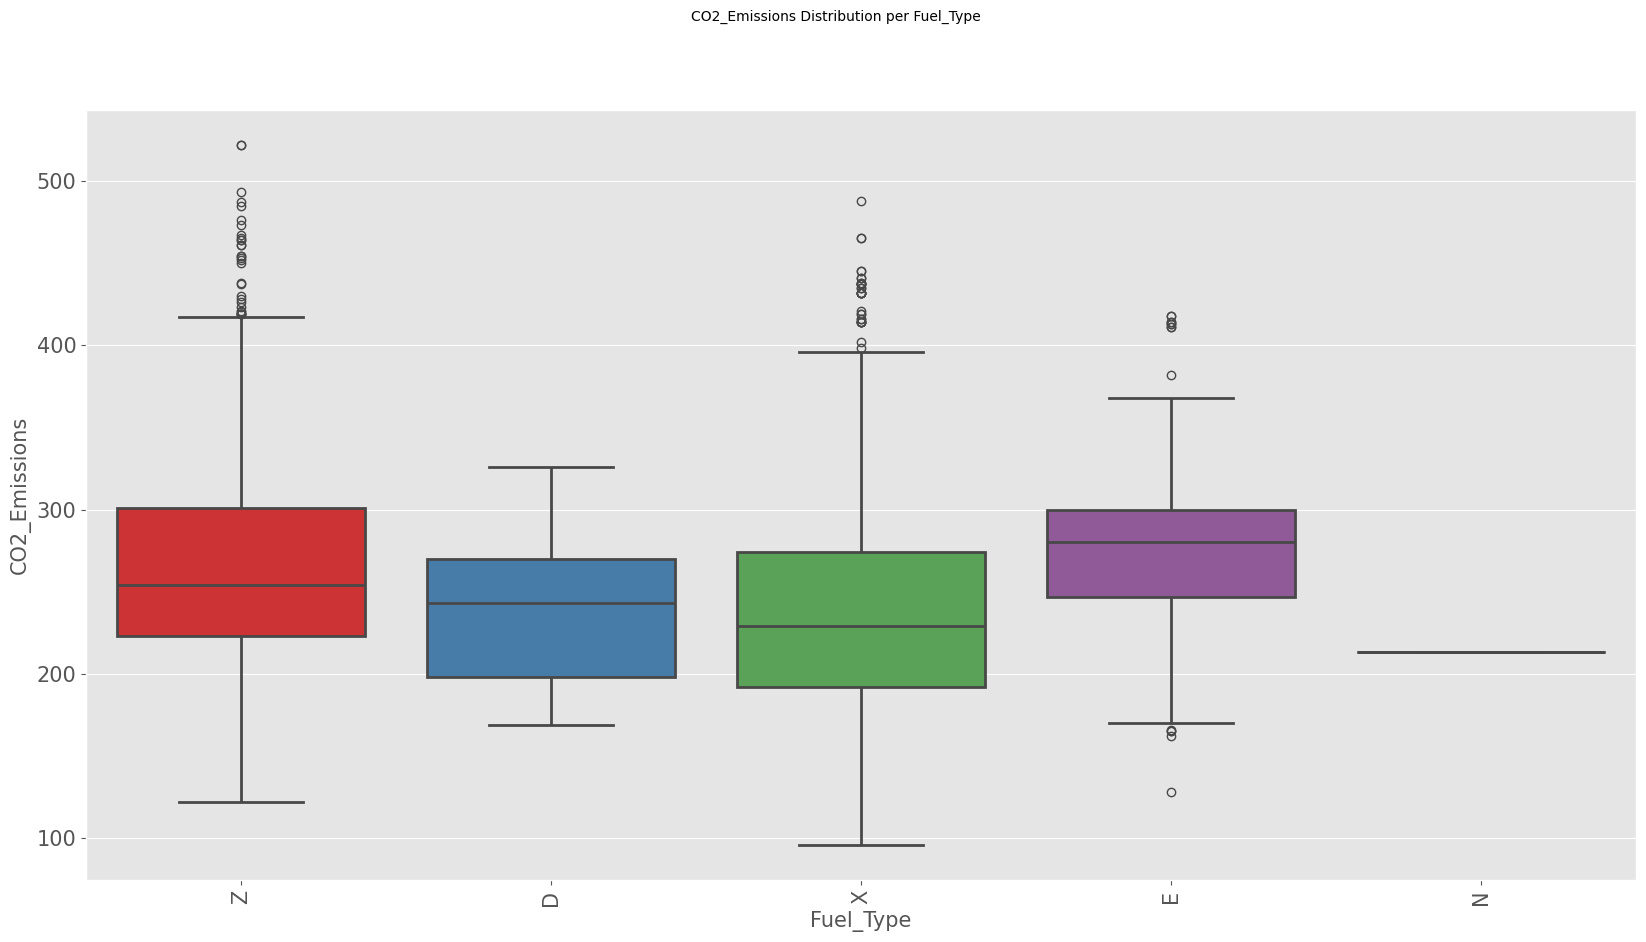

In [ ]:
plot_boxplot2(cat2, var='Fuel_Type')

### Handling Outliers

In [ ]:
# Detect and remove outliers in target variable
# IQR
# Calculate the upper and lower limits
print("Old Shape: ", df_1.shape)
Q1=df_1['CO2_Emissions'].quantile(0.25)
Q3=df_1['CO2_Emissions'].quantile(0.75)
IQR=Q3-Q1
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = df_1[df_1['CO2_Emissions'] > upper].index
lower_array = df_1[df_1['CO2_Emissions'] < lower].index

# Removing the outliers by the target
df_2=df_1.drop(index=upper_array, axis=1)
df_2=df_2.drop(index=lower_array, axis=1)

# Print the new shape of the DataFrame
print("New_Shape: ", df_2.shape)

Old Shape:  (6282, 12)
New_Shape:  (6208, 12)


In [ ]:
# Split data set between target variable and features
X_ = df_2.copy()
y_ = X_['CO2_Emissions']
X_.drop(['CO2_Emissions'], axis=1, inplace=True)
num_=X_[numerical_cols]
cat_=X_[categorical_cols]

In [ ]:
# cap residual outliers on numerical feature
i = 'Engine_Size'
q75, q25 = np.percentile(num_[i].dropna(), [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
num_out = num_.copy()

# Use .loc to set the values within the IQR range
num_out.loc[num_out[i] < min_val, i] = min_val
num_out.loc[num_out[i] > max_val, i] = max_val

In [ ]:
# cap residual outliers on numerical feature
i = 'Cylinders'
q75, q25 = np.percentile(num_[i].dropna(), [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
num_out = num_.copy()

# Use .loc to set the values within the IQR range
num_out.loc[num_out[i] < min_val, i] = min_val
num_out.loc[num_out[i] > max_val, i] = max_val

In [ ]:
# cap residual outliers on numerical feature
i = 'Fuel_Consumption_City'
q75, q25 = np.percentile(num_[i].dropna(), [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
num_out = num_.copy()

# Use .loc to set the values within the IQR range
num_out.loc[num_out[i] < min_val, i] = min_val
num_out.loc[num_out[i] > max_val, i] = max_val

In [ ]:
# cap residual outliers on numerical feature
i = 'Fuel_Consumption_Hwy'
q75, q25 = np.percentile(num_[i].dropna(), [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
num_out = num_.copy()

# Use .loc to set the values within the IQR range
num_out.loc[num_out[i] < min_val, i] = min_val
num_out.loc[num_out[i] > max_val, i] = max_val

In [ ]:
# cap residual outliers on numerical feature
i='Fuel_Consumption_Comb'
q75,q25=np.percentile(num_[i].dropna(), [75,25])
iqr=q75-q25
min_val=q25-(iqr*1.5)
max_val=q75+(iqr*1.5)

# create a copy of the dataframe to avoid Setting With Copy Warning
num_out=num_.copy()

# use .loc to set the values within the IQR range
num_out.loc[num_out[i]<min_val,i]=min_val
num_out.loc[num_out[i]>max_val,i]=max_val

In [ ]:
# cap residual outliers on numerical feature
i = 'Fuel_Consumption_Comb_'
q75, q25 = np.percentile(num_[i].dropna(), [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
num_out = num_.copy()

# Use .loc to set the values within the IQR range
num_out.loc[num_out[i] < min_val, i] = min_val
num_out.loc[num_out[i] > max_val, i] = max_val

In [ ]:
num_out.columns

Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb',
       'Fuel_Consumption_Comb_'],
      dtype='object')

### Encoding Categorical Variables

In [ ]:
# Combine categorical features and target variable
cat2_=pd.concat([cat_,y_], axis=1)

In [ ]:
# calculate the mean target value per category for each feature and capture the result in a dictionary
MAKE_LABELS = cat2_.groupby(['Make'])['CO2_Emissions'].mean().to_dict()
VEHICLE_CLASS_LABELS = cat2_.groupby(['Vehicle_Class'])['CO2_Emissions'].mean().to_dict()
TRASMISSION_LABELS = cat2_.groupby(['Transmission'])['CO2_Emissions'].mean().to_dict()
FUEL_TYPE_LABELS = cat2_.groupby(['Fuel_Type'])['CO2_Emissions'].mean().to_dict()


In [ ]:
# replace for each feature the labels with the mean target values
cat2_['Make'] = cat2_['Make'].map(MAKE_LABELS)
cat2_['Vehicle_Class'] = cat2_['Vehicle_Class'].map(VEHICLE_CLASS_LABELS)
cat2_['Transmission'] = cat2_['Transmission'].map(TRASMISSION_LABELS)
cat2_['Fuel_Type'] = cat2_['Fuel_Type'].map(FUEL_TYPE_LABELS)

In [ ]:
# Create new data subset without the target variable
target_cat = cat2_.drop(['CO2_Emissions'], axis=1)
target_cat.shape

(6208, 4)

In [ ]:
# Display the new subset
target_cat.head()

Make  Vehicle_Class  Transmission   Fuel_Type
0  221.666667     217.641196    275.115385  263.398168
1  221.666667     217.641196    232.157827  263.398168
2  221.666667     217.641196    192.260870  263.398168
3  221.666667     236.413519    240.124780  263.398168
4  221.666667     236.413519    240.124780  263.398168

In [ ]:
# Combine all processed categorical and numerical features
X_all=pd.concat([target_cat, num_out], axis=1)

### Zero Variance Predictors

In [ ]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [ ]:
# Drop features with zero variance
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality Test

In [ ]:
# Perform Normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the normality test result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.726, p=0.000
Sample does not look Gaussian (reject H0)


### Correlated Predictors

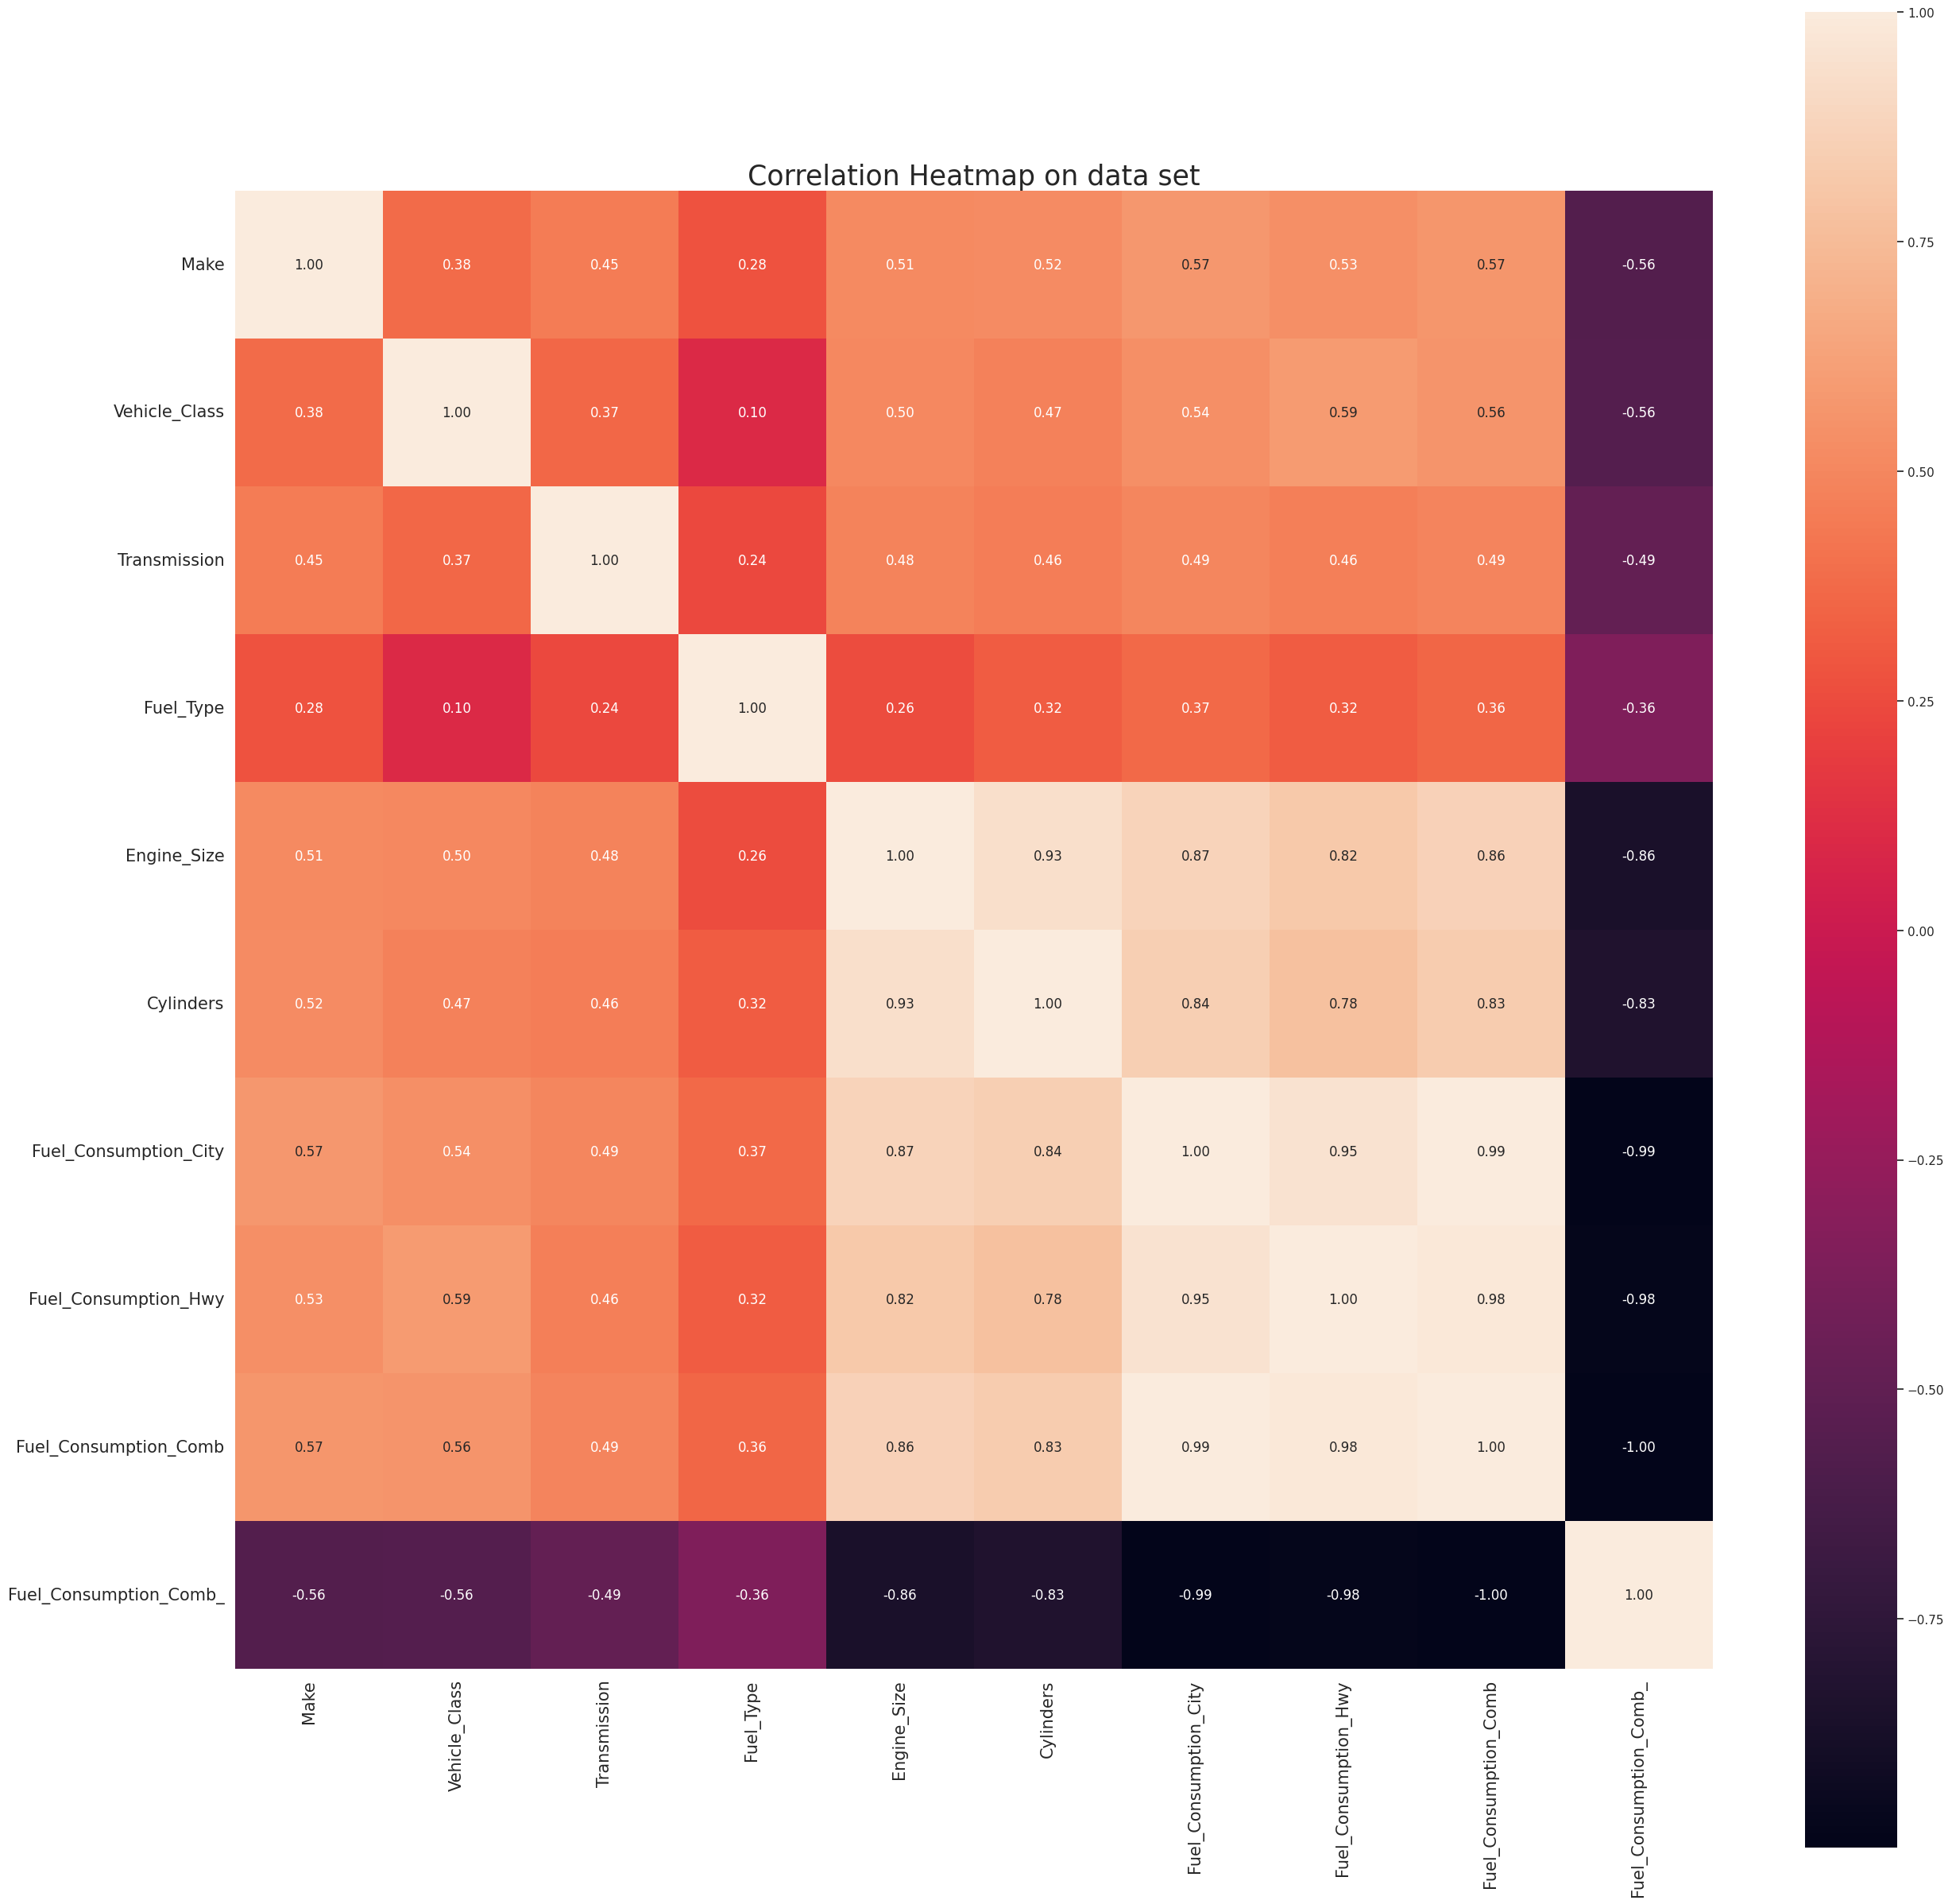

In [ ]:
# Plot Correlation heatmap
corr_matrix = X_all.corr(method='spearman')
sns.set( rc = {'figure.figsize': (30, 30)})
plt.figure()
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [ ]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['Cylinders',
 'Fuel_Consumption_City',
 'Fuel_Consumption_Hwy',
 'Fuel_Consumption_Comb',
 'Fuel_Consumption_Comb_']

In [ ]:
# Drop highly correlated features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [ ]:
# Look at the new shape of data set
X_all_f.shape

(6208, 5)

### Split Data Set

In [ ]:
# Split the dataset into train/calibration/test split
X_train_cal, X_test, y_train_cal, y_test = train_test_split(X_all_f, y_, test_size=0.1, random_state=0)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size=0.1, random_state=0)

In [ ]:
# Save split datasets to CSV files

In [ ]:
X_train.to_csv('X_train.csv', index=False)

In [ ]:
y_train.to_csv('y_train.csv', index=False)

In [ ]:
X_cal.to_csv('X_cal.csv', index=False)

In [ ]:
y_cal.to_csv('y_cal.csv', index=False)

In [ ]:
X_test.to_csv('X_test.csv', index=False)

In [ ]:
y_test.to_csv('y_test.csv',index=False)

### Modelling

In [ ]:
# Set alpha value for the conformal prediction methods
alpha=0.1

# LightGBM & QuantileRegression

### Fine-tuning LGBM model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective':'quantile',
#        'alpha':0.5,
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
#    }

#    lgbm = LGBMRegressor(**params)

#    cv=KFold(n_splits=5, shuffle=True)

#    rmse_scores = []


#    for train_index, val_index in cv.split(X_train):
#        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        lgbm.fit(X_tr, y_tr)
#        pred_val = lgbm.predict(X_val)

#        rmse_score = np.sqrt(mean_squared_error(y_val, pred_val))
#        rmse_scores.append(rmse_score)

#    return np.mean(rmse_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [ ]:
#best_params

#### LGBM Optimized Estimator

In [ ]:
# Initialize and configure the LGBMRegressor with optimized parameters
LGBM = LGBMRegressor(
        objective='quantile',
        alpha=0.5,
        n_estimators= 604,
        learning_rate= 0.028182937892429497,
        max_depth= 7,
        min_child_samples=39,
        num_leaves= 130,
        n_jobs=-1,
        random_state=0)

### Fine-tuning QR model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'quantile':0.5,
#        'solver':'highs',
#        'alpha': trial.suggest_loguniform('alpha', 0.1, 1),
#          }

#    QR = QuantileRegressor(**params)

#    cv=KFold(n_splits=5, shuffle=True)

#    rmse_scores = []


#    for train_index, val_index in cv.split(X_train):
#        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        QR.fit(X_tr, y_tr)
#        pred_val = LR.predict(X_val)

#        rmse_score = np.sqrt(mean_squared_error(y_val, pred_val))
#        rmse_scores.append(rmse_score)

#    return np.mean(rmse_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [ ]:
#best_params

### QR Optimized Estimator

In [ ]:
# Initialize and configure the QuantileRegressor with optimized parameters
np.random.seed(0)
QR=QuantileRegressor(quantile=0.5,alpha=0.29643031153893773, solver='highs')

### CP Methods

#### CQR

In [ ]:
# Initialize and fit MAPIE conformal quantile regressor using LightGBM estimator
np.random.seed(0)
LGBM_cqr = MapieQuantileRegressor(estimator=LGBM, cv="split", alpha=alpha, method= "quantile")
LGBM_cqr.fit(X_train, y_train, X_calib=X_cal, y_calib=y_cal, random_state=0)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 5
[LightGBM] [Info] Start training from score 170.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

MapieQuantileRegressor(cv='split',
                       estimator=LGBMRegressor(alpha=0.5,
                                               learning_rate=0.028182937892429497,
                                               max_depth=7,
                                               min_child_samples=39,
                                               n_estimators=604, n_jobs=-1,
                                               num_leaves=130,
                                               objective='quantile',
                                               random_state=0))

In [ ]:
# Save the fitted model to a file
filename = 'LGBM_cqr_model.sav'
pickle.dump(LGBM_cqr, open(filename, 'wb'))

In [ ]:
# Initialize and fit MAPIE conformal quantile regressor using QuantileRegressor estimator
np.random.seed(0)
QR_cqr = MapieQuantileRegressor(estimator=QR, cv="split", alpha=alpha, method= "quantile")
QR_cqr.fit(X_train, y_train, X_calib=X_cal, y_calib=y_cal, random_state=0)

MapieQuantileRegressor(cv='split',
                       estimator=QuantileRegressor(alpha=0.29643031153893773,
                                                   solver='highs'))

In [ ]:
# Save the fitted model to a file
filename = 'QR_cqr_model.sav'
pickle.dump(QR_cqr, open(filename, 'wb'))

### Naive

In [ ]:
# Initialize and fit MAPIE naive regressor using LightGBM estimator
np.random.seed(0)
LGBM_naive = MapieRegressor(estimator=LGBM, method= "naive")
LGBM_naive.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 5
[LightGBM] [Info] Start training from score 244.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

MapieRegressor(estimator=LGBMRegressor(alpha=0.5,
                                       learning_rate=0.028182937892429497,
                                       max_depth=7, min_child_samples=39,
                                       n_estimators=604, n_jobs=-1,
                                       num_leaves=130, objective='quantile',
                                       random_state=0),
               method='naive')

In [ ]:
# Save the fitted model to a file
filename = 'LGBM_naive_model.sav'
pickle.dump(LGBM_naive, open(filename, 'wb'))

In [ ]:
# Initialize and fit MAPIE naive regressor using QuantileRegressor estimator
np.random.seed(0)
QR_naive = MapieRegressor(estimator=QR,method= "naive")
QR_naive.fit(X_train, y_train)

MapieRegressor(estimator=QuantileRegressor(alpha=0.29643031153893773,
                                           solver='highs'),
               method='naive')

In [ ]:
# Save the fitted model to a file
filename = 'QR_naive_model.sav'
pickle.dump(QR_naive, open(filename, 'wb'))

#### Jacknife

In [ ]:
# Initialize and fit MAPIE jackknife regressor using LigthGBM estimator
np.random.seed(0)
LGBM_jacknife = MapieRegressor(estimator=LGBM, method= "base", cv=5)
LGBM_jacknife.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 5
[LightGBM] [Info] Start training from score 244.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

MapieRegressor(cv=5,
               estimator=LGBMRegressor(alpha=0.5,
                                       learning_rate=0.028182937892429497,
                                       max_depth=7, min_child_samples=39,
                                       n_estimators=604, n_jobs=-1,
                                       num_leaves=130, objective='quantile',
                                       random_state=0),
               method='base')

In [ ]:
# Save the fitted model to a file
filename = 'LGBM_jacknife_model.sav'
pickle.dump(LGBM_jacknife, open(filename, 'wb'))

In [ ]:
# Initialize and fit MAPIE jackknife regressor using QuantileRegressor estimator
np.random.seed(0)
QR_jacknife = MapieRegressor(estimator=QR,method= "base", cv=5)
QR_jacknife.fit(X_train, y_train)

MapieRegressor(cv=5,
               estimator=QuantileRegressor(alpha=0.29643031153893773,
                                           solver='highs'),
               method='base')

In [ ]:
# Save the fitted model to a file
filename = 'QR_jacknife_model.sav'
pickle.dump(QR_jacknife, open(filename, 'wb'))

#### Jacknife+

In [ ]:
# Initialize and fit MAPIE jackknife+ regressor using LigthGBM estimator
np.random.seed(0)
LGBM_jacknife_plus = MapieRegressor(estimator=LGBM, method= "plus", cv=5)
LGBM_jacknife_plus.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 5
[LightGBM] [Info] Start training from score 244.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

MapieRegressor(cv=5,
               estimator=LGBMRegressor(alpha=0.5,
                                       learning_rate=0.028182937892429497,
                                       max_depth=7, min_child_samples=39,
                                       n_estimators=604, n_jobs=-1,
                                       num_leaves=130, objective='quantile',
                                       random_state=0))

In [ ]:
# Save the fitted model to a file
filename = 'LGBM_jacknife_plus_model.sav'
pickle.dump(LGBM_jacknife_plus, open(filename, 'wb'))

In [ ]:
# Initialize and fit MAPIE jackknife+ regressor using QuantileRegressor estimator
np.random.seed(0)
QR_jacknife_plus = MapieRegressor(estimator=QR,method= "plus", cv=5)
QR_jacknife_plus.fit(X_train, y_train)

MapieRegressor(cv=5,
               estimator=QuantileRegressor(alpha=0.29643031153893773,
                                           solver='highs'))

In [ ]:
# Save the fitted model to a file
filename = 'QR_jacknife_plus_model.sav'
pickle.dump(QR_jacknife_plus, open(filename, 'wb'))

#### Prediction

In [ ]:
# Calculate predictions and evaluation metrics for each model

In [ ]:
LGBM_cqr_results, LGBM_cqr_predictions_df = calculate_predictions_and_scores(LGBM_cqr,X_test,"QRegressor", alpha)
LGBM_naive_results, LGBM_naive_predictions_df = calculate_predictions_and_scores(LGBM_naive,X_test,"Regressor",alpha)
LGBM_jacknife_results, LGBM_jacknife_predictions_df = calculate_predictions_and_scores(LGBM_jacknife,X_test,"Regressor",alpha)
LGBM_jacknife_plus_results, LGBM_jacknife_plus_predictions_df = calculate_predictions_and_scores(LGBM_jacknife_plus,X_test,"Regressor",alpha)

In [ ]:
QR_cqr_results, QR_cqr_predictions_df = calculate_predictions_and_scores(QR_cqr,X_test,"QRegressor", alpha)
QR_naive_results, QR_naive_predictions_df = calculate_predictions_and_scores(QR_naive,X_test,"Regressor",alpha)
QR_jacknife_results, QR_jacknife_predictions_df = calculate_predictions_and_scores(QR_jacknife,X_test,"Regressor",alpha)
QR_jacknife_plus_results, QR_jacknife_plus_predictions_df = calculate_predictions_and_scores(QR_jacknife_plus,X_test,"Regressor",alpha)

### Results

In [ ]:
# Define a function to print results with a title
def print_with_title(df, title):
    print(f"{title}\n")
    print(df)

In [ ]:
# Print results for each model

In [ ]:
print_with_title(pd.DataFrame([LGBM_cqr_results]), "LGBM_cqr_results")

LGBM_cqr_results

   coverage      width  score_lower  score_median  score_upper
0  0.900161  47.735343    30.133297     16.153741    31.025284


In [ ]:
print_with_title(pd.DataFrame([QR_cqr_results]), "QR_cqr_results")

QR_cqr_results

   coverage       width  score_lower  score_median  score_upper
0  0.916264  129.433474    71.927238     37.019276    78.444138


In [ ]:
print_with_title(pd.DataFrame([LGBM_naive_results]), "LGBM_naive_results")

LGBM_naive_results

   coverage      width  score_lower  score_median  score_upper
0  0.884058  49.756283     29.85862     16.153741     29.46512


In [ ]:
print_with_title(pd.DataFrame([QR_naive_results]), "QR_naive_results")

QR_naive_results

   coverage       width  score_lower  score_median  score_upper
0  0.901771  117.540194    71.368786     37.019276    67.492211


In [ ]:
print_with_title(pd.DataFrame([LGBM_jacknife_results]), "LGBM_jacknife_results")

LGBM_jacknife_results

   coverage      width  score_lower  score_median  score_upper
0  0.909823  55.340948    32.242526     16.153741    31.837344


In [ ]:
print_with_title(pd.DataFrame([QR_jacknife_results]), "QR_jacknife_results")

QR_jacknife_results

   coverage       width  score_lower  score_median  score_upper
0  0.901771  117.833249    71.494189     37.019276    67.614878


In [ ]:
print_with_title(pd.DataFrame([LGBM_jacknife_plus_results]), "LGBM_jacknife_plus_results")

LGBM_jacknife_plus_results

   coverage      width  score_lower  score_median  score_upper
0  0.904992  55.647697    32.592686     16.153741    32.177425


In [ ]:
print_with_title(pd.DataFrame([QR_jacknife_plus_results]), "QR_jacknife_plus_results")

QR_jacknife_plus_results

   coverage       width  score_lower  score_median  score_upper
0  0.901771  117.778125     71.51966     37.019276    67.515744


### Visualization Results

In [ ]:
# Prepare model results and predictions for plotting (LGBM models)
LGBM_models_predictions = [
    ("LGBM_CQR", LGBM_cqr_predictions_df),
    ("LGBM_Naive", LGBM_naive_predictions_df),
    ("LGBM_Jackknife", LGBM_jacknife_predictions_df),
    ("LGBM_Jackknife+", LGBM_jacknife_plus_predictions_df)
]


In [ ]:
# Prepare model results and predictions for plotting (QR models)
QR_models_predictions = [
    ("QR_CQR", QR_cqr_predictions_df),
    ("QR_Naive", QR_naive_predictions_df),
    ("QR_Jackknife", QR_jacknife_predictions_df),
    ("QR_Jackknife+", QR_jacknife_plus_predictions_df)
]

LGBM model errors


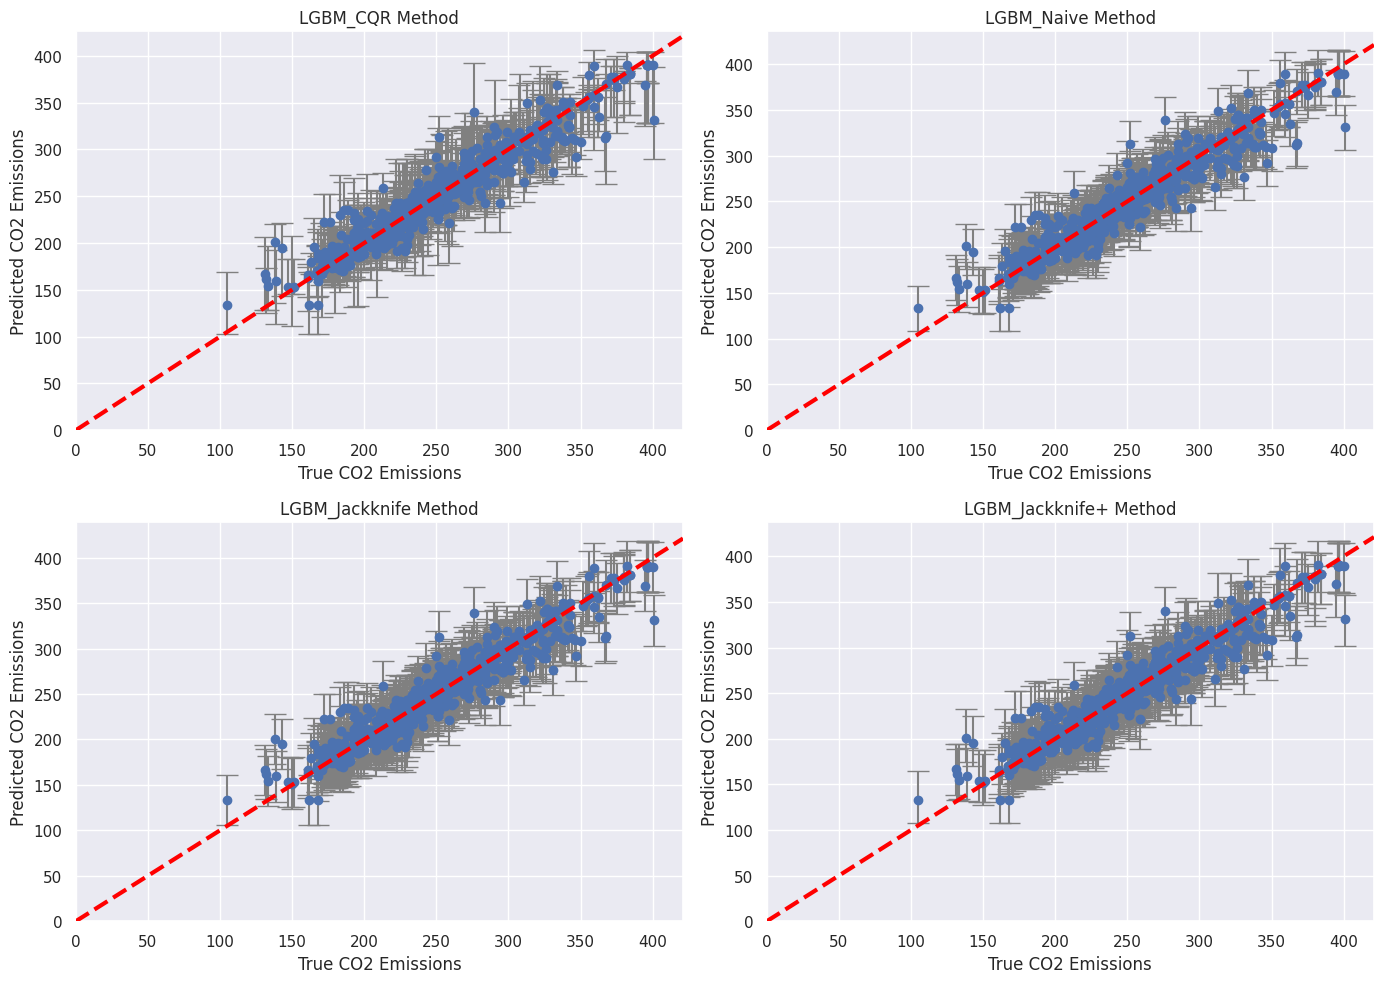

In [ ]:
# Plot errors for LGBM models
print("LGBM model errors")
plot_error(LGBM_models_predictions, calculate_errors)


QR model errors


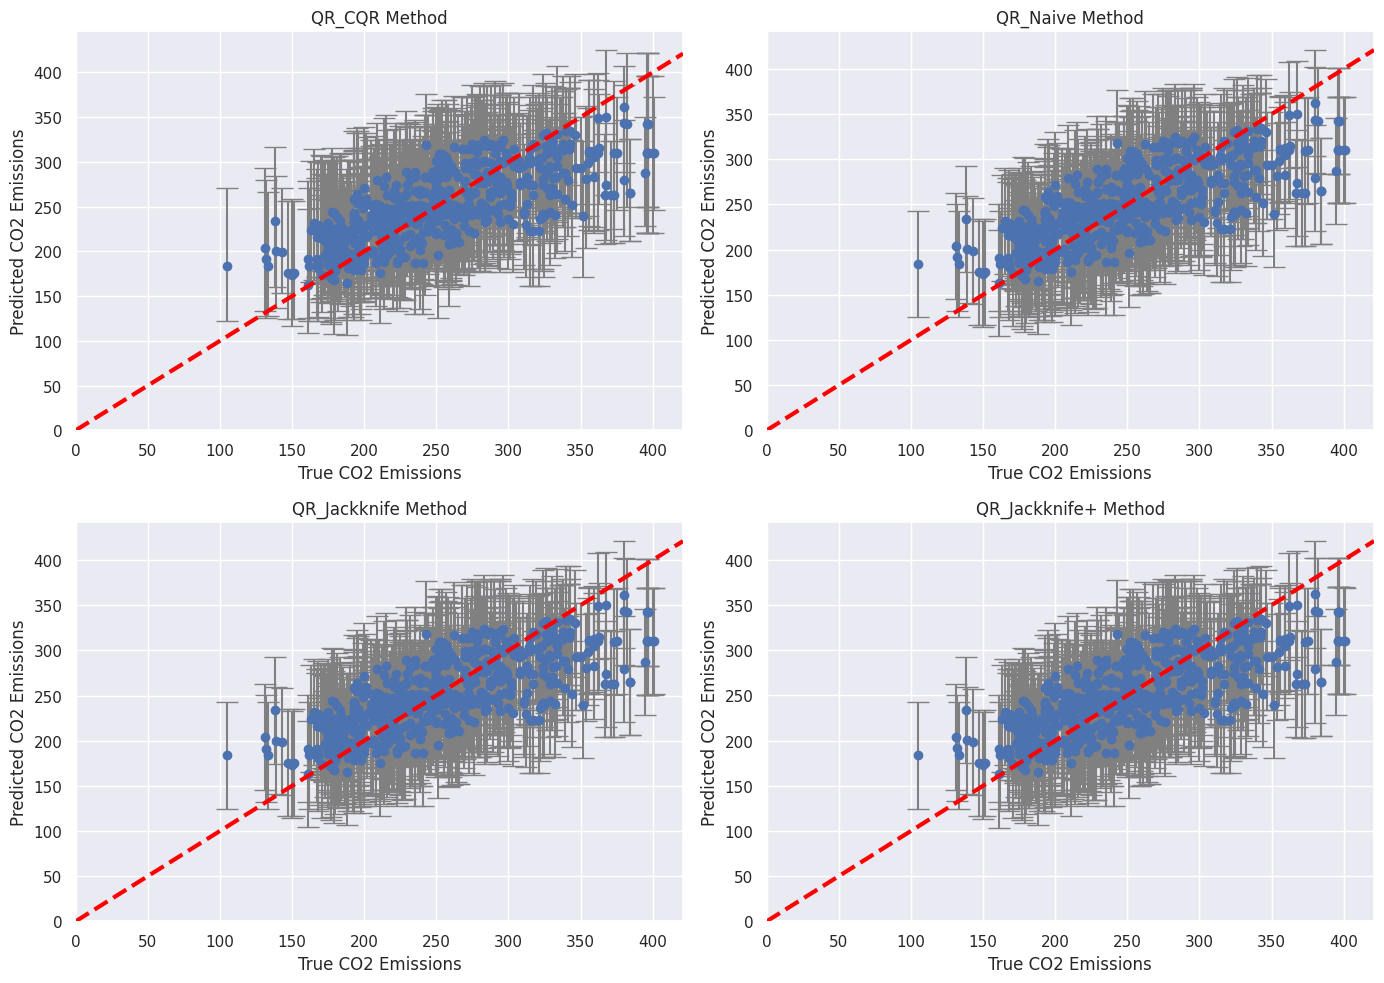

In [ ]:
# Plot errors for QR models
print("QR model errors")
plot_error(QR_models_predictions, calculate_errors)

LGBM model predictions


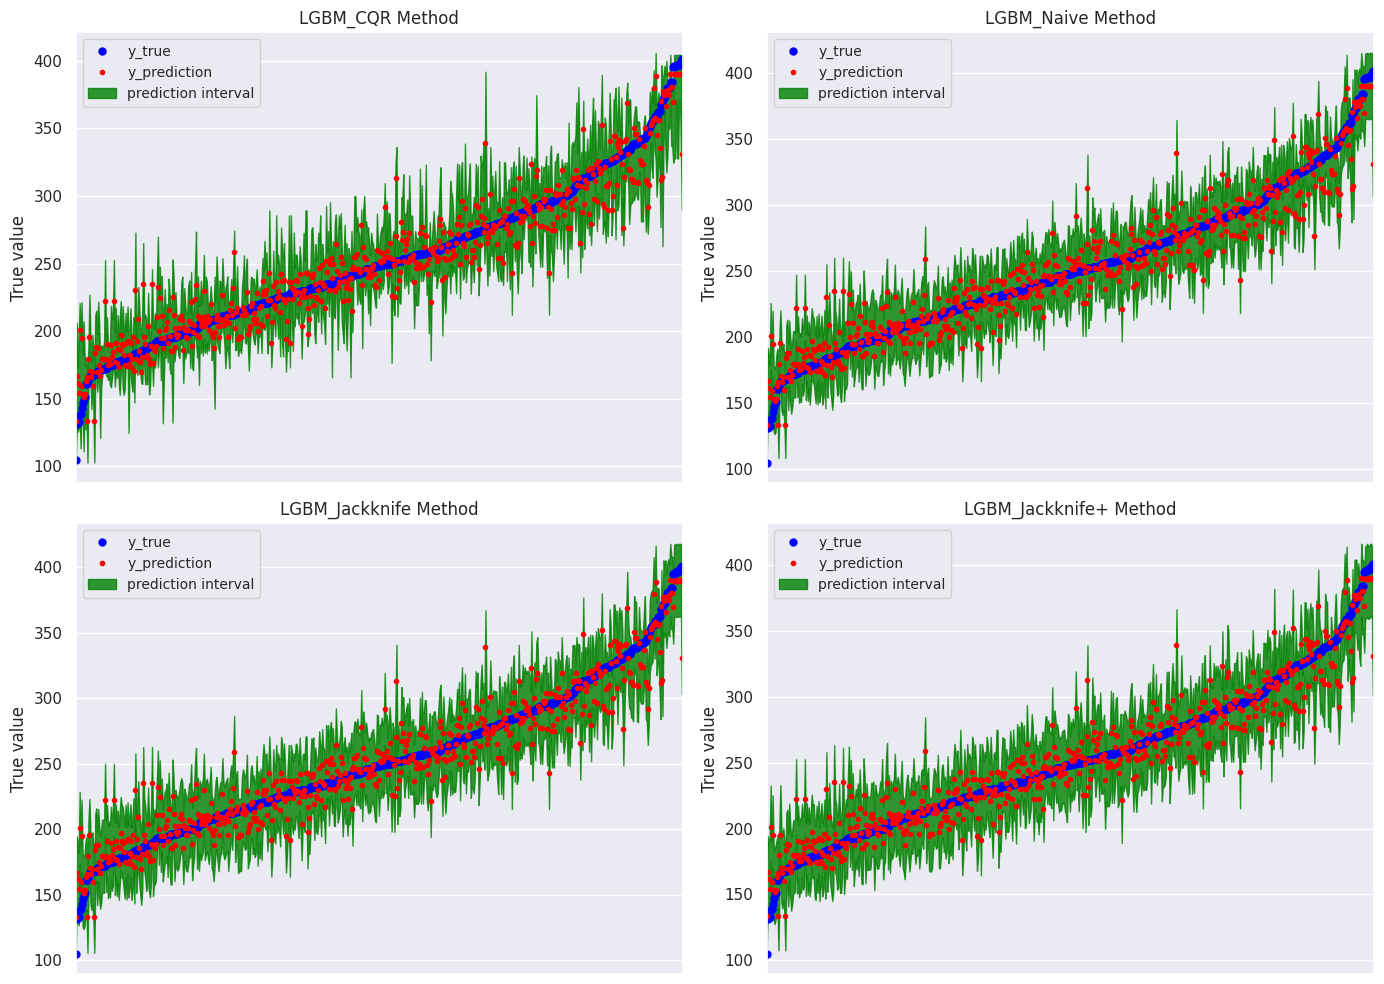

In [ ]:
# Plot predictions for LGBM models
print("LGBM model predictions")
plot_prediction(LGBM_models_predictions)

QR model predictions


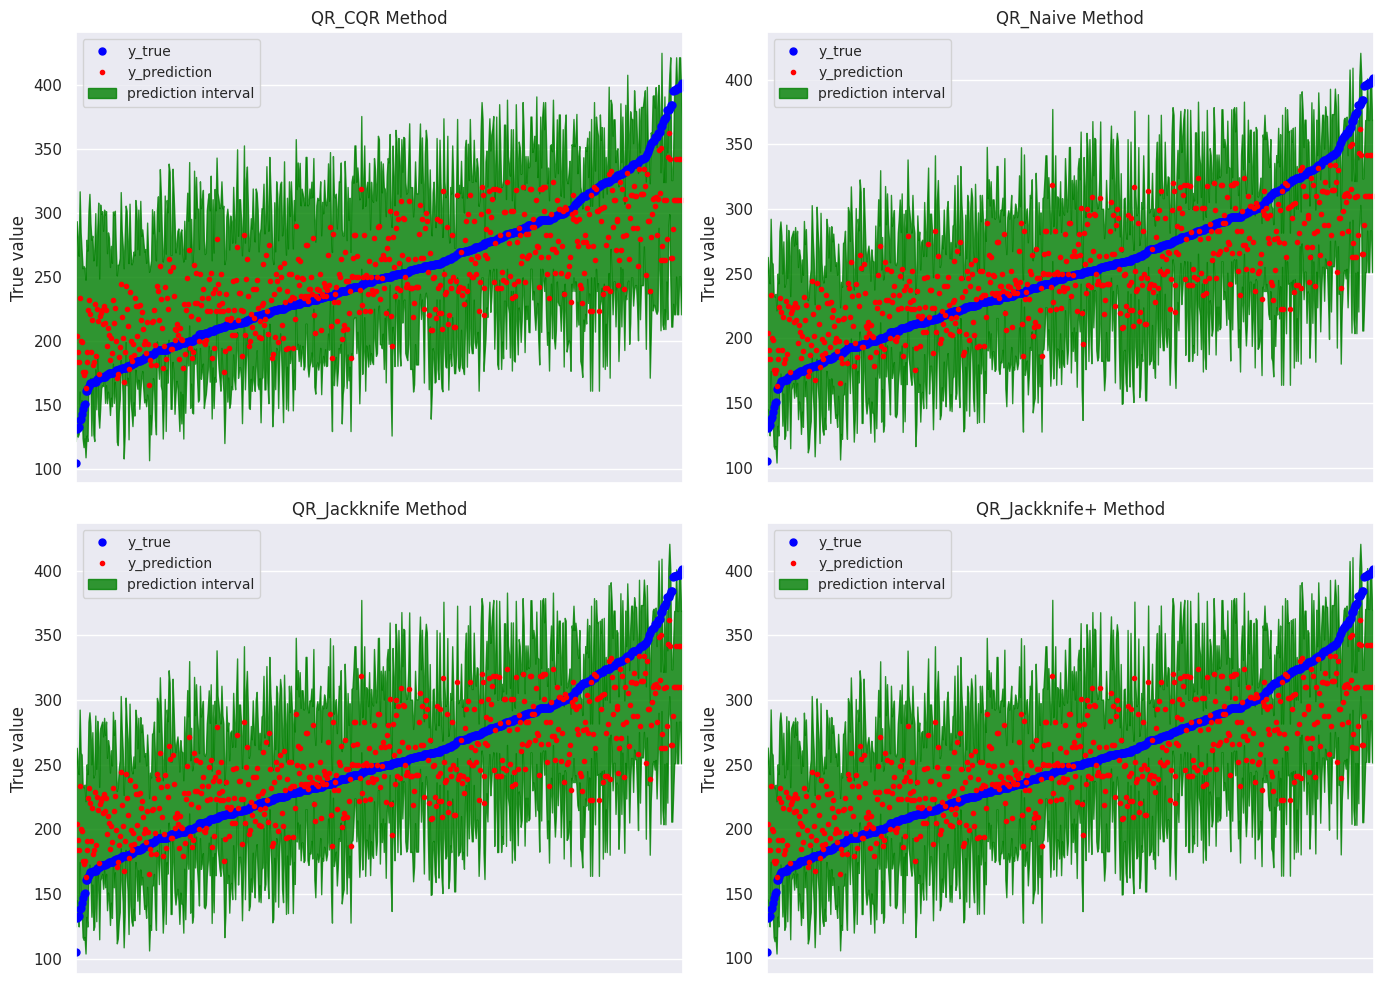

In [ ]:
# Plot predictions for QR models
print("QR model predictions")
plot_prediction(QR_models_predictions)

LGBM binned coverage


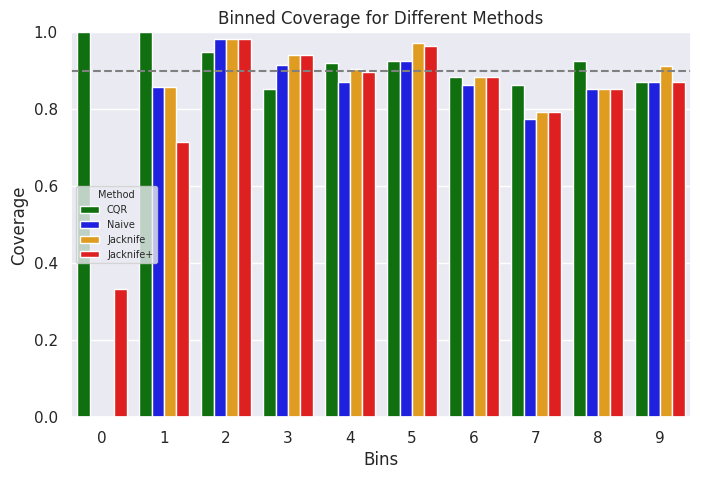

In [ ]:
# Calculate and plot binned coverage for LGBM models
binned_coverage_df = main_binned_metric(LGBM_cqr_predictions_df, LGBM_naive_predictions_df, LGBM_jacknife_predictions_df, LGBM_jacknife_plus_predictions_df, metric='coverage')
print("LGBM binned coverage")
plot_binned_metric('coverage', binned_coverage_df)



LGBM binned width


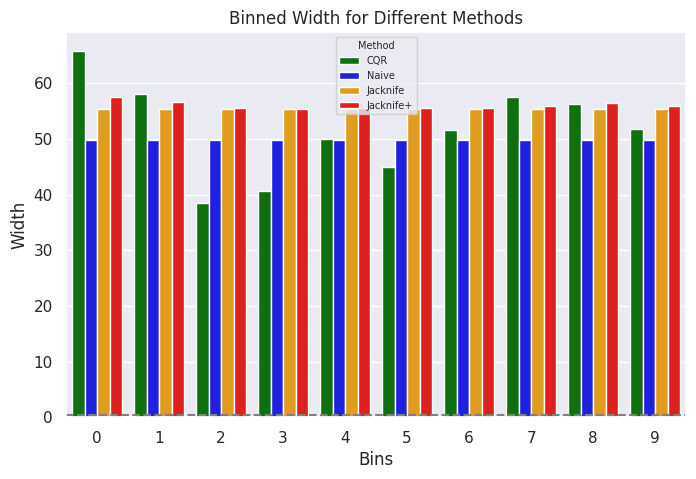

In [ ]:
# Calculate and plot binned width for LGBM models
binned_width_df = main_binned_metric(LGBM_cqr_predictions_df, LGBM_naive_predictions_df, LGBM_jacknife_predictions_df, LGBM_jacknife_plus_predictions_df, metric='width')
print("LGBM binned width")
plot_binned_metric('width', binned_width_df)

QR binned coverage


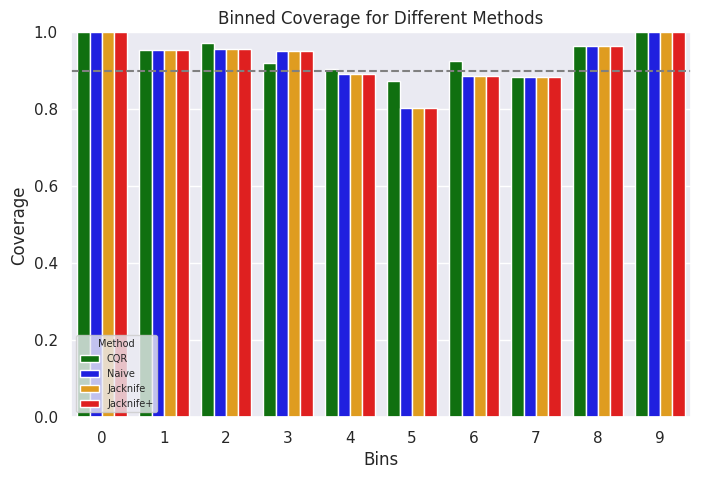

In [ ]:
# Calculate and plot binned coverage for QR models
binned_coverage_df = main_binned_metric(QR_cqr_predictions_df, QR_naive_predictions_df, QR_jacknife_predictions_df, QR_jacknife_plus_predictions_df, metric='coverage')
print("QR binned coverage")
plot_binned_metric('coverage', binned_coverage_df)


QR binned width


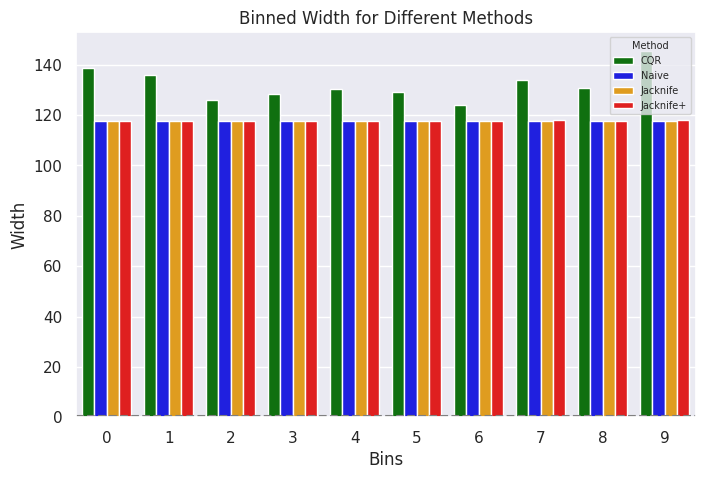

In [ ]:
# Calculate and plot binned width for QR models
binned_width_df = main_binned_metric(QR_cqr_predictions_df, QR_naive_predictions_df, QR_jacknife_predictions_df, QR_jacknife_plus_predictions_df, metric='width')
print("QR binned width")
plot_binned_metric('width', binned_width_df)

### Feature Importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 5
[LightGBM] [Info] Start training from score 244.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

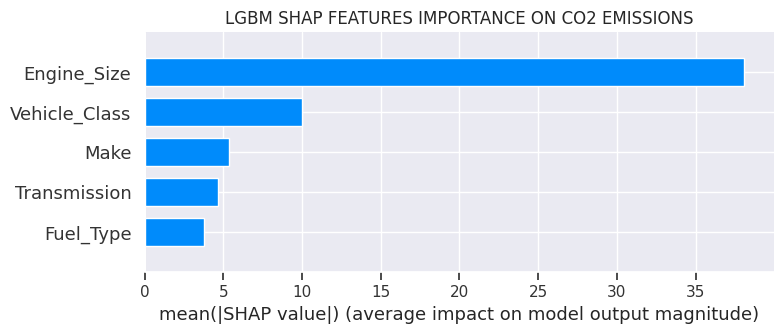

In [ ]:
# Train a LightGBM model and calculate SHAP values for global feature importance
# Create and fit a LightGBM regressor with specified parameters
LGBM_ = LGBMRegressor(
        objective='quantile',
        alpha=0.5,
        n_estimators= 604,
        learning_rate= 0.028182937892429497,
        max_depth= 7,
        min_child_samples=39,
        num_leaves= 130,
        n_jobs=-1,
        random_state=0).fit(X_train, y_train)
# Create a SHAP explainer for the LightGBM model
LGBM_explainer = shap.TreeExplainer(LGBM_)
# Calculate SHAP values for the test dataset
LGBM_shap_values = LGBM_explainer.shap_values(X_test)
# Set figure size for the plot
plt.rcParams['figure.figsize'] = (5,5)
# Set title for the SHAP feature importance plot
plt.title("LGBM SHAP FEATURES IMPORTANCE ON CO2 EMISSIONS")
# Plot SHAP summary plot for the LightGBM model
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

In [ ]:
# Save the fitted LightGBM model to a file
filename = 'LGBM_explainer_model.sav'
pickle.dump(LGBM_, open(filename, 'wb'))

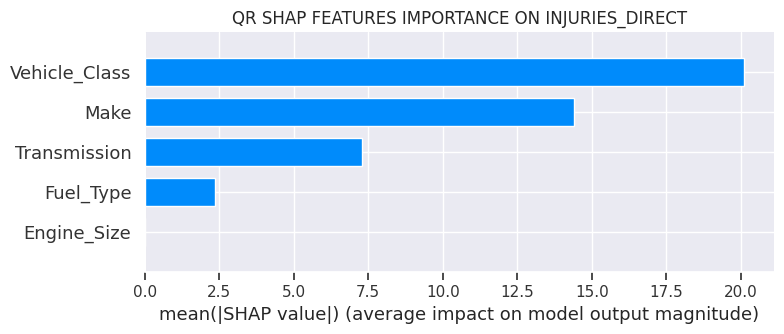

In [ ]:
# Train a QuantileRegressor model and calculate SHAP values for global feature importance

# Create and fit a QuantileRegressor with specified parameters
QR_ = QuantileRegressor(quantile=0.5, alpha=0.29643031153893773, solver='highs').fit(X_train, y_train)
# Create a SHAP masker for the QuantileRegressor model
masker = shap.maskers.Independent(X_train)
# Create a SHAP explainer for the QuantileRegressor model
QR_explainer = shap.LinearExplainer(QR_, masker=masker)
# Calculate SHAP values for the test dataset
QR_shap_values = QR_explainer.shap_values(X_test)
# Set figure size for the plot
plt.rcParams['figure.figsize'] = (5,5)
# Set title for the SHAP feature importance plot
plt.title("QR SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
# Plot SHAP summary plot for the QuantileRegressor model
shap.summary_plot(QR_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

In [ ]:
# Save the fitted QuantileRegressor model to a file
filename = 'QR_explainer_model.sav'
pickle.dump(QR_, open(filename, 'wb'))

### References

https://mapie.readthedocs.io/en/latest/index.html

https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction

https://christophmolnar.com/books/conformal-prediction/

https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles
